<a href="https://colab.research.google.com/github/NathanielRose/eeg-294/blob/master/Project_Report_SH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install git+git://github.com/gumpy-bci/gumpy.git

  Cloning git://github.com/gumpy-bci/gumpy.git to /tmp/pip-req-build-fuzt9w0h
  Running command git clone -q git://github.com/gumpy-bci/gumpy.git /tmp/pip-req-build-fuzt9w0h
  Created wheel for gumpy: filename=gumpy-0.5.0-cp36-none-any.whl size=32999 sha256=5ee2a7cb2aec4ab9de12d289b7a0f6ffed6bca6fd617309e6b5e01b2e0b7c4bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-9xnd6qjq/wheels/cf/ee/4d/dfa04a0d04ffb1ca36f436f3fef4817e9e23bfec03dd772913
Successfully built gumpy


In [0]:
!git clone https://github.com/NathanielRose/eeg-294.git

Cloning into 'eeg-294'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 206 (delta 85), reused 89 (delta 13), pack-reused 0
Receiving objects: 100% (206/206), 3.81 MiB | 4.96 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [0]:
##Import packages##

%reset
%matplotlib inline

from __future__ import print_function
import os; os.environ["THEANO_FLAGS"] = "device=gpu0"
import os.path
from datetime import datetime
import sys

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
##import gumpy modules##
sys.path.append('gumpy/gumpy/')
import gumpy

sys.path.append('eeg-294/gumpy-deeplearning')
import models

sys.path.append('eeg-294/gumpy-deeplearning/models/')
import utils

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [0]:
##Setup parameters##
DEBUG = True
CLASS_COUNT = 2
DROPOUT = 0.2   # dropout rate in float

# parameters for filtering data
FS = 250
LOWCUT = 2
HIGHCUT = 60
ANTI_DRIFT = 0.5
CUTOFF = 50.0 # freq to be removed from signal (Hz) for notch filter
Q = 30.0  # quality factor for notch filter 
W0 = CUTOFF/(FS/2)
AXIS = 0

#set random seed
SEED = 42
KFOLD = 5

# Get Data

In [0]:
%%bash
%%capture 

export fileid=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
export filename=grazdata.zip


wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O- \
     | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt

wget --load-cookies cookies.txt -O $filename \
     'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)

bash: line 1: fg: no job control
--2019-12-21 16:12:47--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
Resolving docs.google.com (docs.google.com)... 172.217.204.100, 172.217.204.138, 172.217.204.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

     0K ...                                                    20.6M=0s

2019-12-21 16:12:47 (20.6 MB/s) - written to stdout [3247]

--2019-12-21 16:12:47--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb&confirm=LTmZ
Resolving docs.google.com (docs.google.com)... 173.194.214.101, 173.194.214.138, 173.194.214.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.214.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-94-docs.googleusercontent.com/docs/securesc/ha0ro937gc

In [0]:
!unzip grazdata.zip

Archive:  grazdata.zip
mapname:  conversion of  failed
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


In [0]:
!unzip grazdata

Archive:  grazdata.zip
mapname:  conversion of  failed
replace B03T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


In [0]:
#load data
subj = 'B01'

grazb_data = gumpy.data.GrazB('', subj)
grazb_data.load()


In [0]:
grazb_data.print_stats()

Data identification: GrazB-B01
EEG-data shape: (1626266, 3)
Trials data shape:  (324,)
Labels shape:  (324,)
Total length of single trial:  8
Sampling frequency of EEG data: 250
Interval for motor imagery in trial:  [4, 7]
Classes possible:  [0 1]


# Functions

In [0]:
#train data follos format [x, y].  Same with val_data
def run_model(model, model_name, epochs, train_data, val_split, batch_size, monitor_index):
    # save best weights
    if os.path.isdir('logs'):
      log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    else:
      os.mkdir('logs')
      log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
    checkpointer = ModelCheckpoint('checkpoints/' + '%s.h5'%model_name, monitor=monitor_index, verbose=1,save_best_only=True, mode='auto', period=1)
    

    # stop if the model does not improve for 15 epoches
    stoppointer = EarlyStopping(monitor=monitor_index, min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    # run model
    history = model.fit(train_data[0], train_data[1], epochs=epochs,
                   shuffle=True,
                   batch_size=batch_size, validation_split = val_split,
                   callbacks=[checkpointer, stoppointer], verbose=2)
    return history


#saves model to json file saves model weights to h5 file
def save_model(model, model_name, working_dir):

    model_json = model.to_json()
    if os.path.isdir('models'):
      # save model to json
      with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)
    else:
      os.mkdir('models')
      with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)

    #save model weights
    model.save_weights(working_dir +'models/' + '%s_weights.h5'%model_name)

# draw the training curves
def draw_graphs(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

# sCNN

## og sCNN

In [0]:
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Conv2D, Dropout, BatchNormalization, \
                         Reshape, Activation, Flatten, AveragePooling2D, Conv3D

In [0]:
# now that the dataset is setup, we can load the data. This will be handled from within the utils function, 
# which will first load the data and subsequently filter it using a notch and a bandpass filter.
# the utility function will then return the training data.
x_train, y_train = utils.load_preprocess_data(grazb_data, True, LOWCUT, HIGHCUT, W0, Q, ANTI_DRIFT, CLASS_COUNT, CUTOFF, AXIS, FS)

Band-pass filtering the data in frequency range from 2.0 Hz to 60.0 Hz... 
Data loaded and processed successfully!


In [0]:
#Augment Data
x_augmented, y_augmented = gumpy.signal.sliding_window(data = x_train[:,:,:],
                                                          labels = y_train[:,:],
                                                          window_sz = 4 * FS,
                                                          n_hop = FS // 10,
                                                          n_start = FS * 1)
x_subject = x_augmented
y_subject = y_augmented
x_subject = np.rollaxis(x_subject, 2, 1)
x_subject = np.rollaxis(x_subject, 1)
x_subject = np.rollaxis(x_subject, 2, 1)



In [0]:
x_subject = x_augmented
y_subject = y_augmented
x_subject = np.rollaxis(x_subject, 2, 1)
# x_subject = np.rollaxis(x_subject, 1)
# x_subject = np.rollaxis(x_subject, 2, 1)
x_subject.shape

(10044, 3, 1000)

In [0]:
x_subject = np.expand_dims(x_subject, axis =3)
x_subject.shape

(10044, 3, 1000, 1)

In [0]:
###MODEL###

model = Sequential()
# Conv Block 1
model.add(Conv2D(input_shape=(3, 1000, 1), filters=40, kernel_size=(1, 25), strides=(1, 1),
                padding='valid', activation=None))
model.add(Reshape(target_shape=(3, 976, 40, 1)))
# model.add(Dropout(0.5))

# Conv Block 2
model.add(Conv3D(filters=40, kernel_size=(3, 1, 40), padding='valid',
                data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation(keras.backend.square))  # custom squaring activation function
model.add(Flatten())
model.add(Reshape(target_shape=(976, 40, 1)))
# model.add(Dropout(0.5))
# Pooling
model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
model.add(Activation(keras.backend.log))  # custom log function

# Classification
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

  # compile the model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 3, 976, 40)        1040      
_________________________________________________________________
reshape_19 (Reshape)         (None, 3, 976, 40, 1)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 1, 976, 1, 40)     4840      
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 976, 1, 40)     160       
_________________________________________________________________
activation_19 (Activation)   (None, 1, 976, 1, 40)     0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 39040)             0         
_________________________________________________________________
reshape_20 (Reshape)         (None, 976, 40, 1)      

Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.2155 - acc: 0.9163 - val_loss: 1.2668 - val_acc: 0.5249

Epoch 00001: val_loss improved from inf to 1.26677, saving model to checkpoints/GRAZ_sCNN__run_1.h5
Epoch 2/100
 - 47s - loss: 0.2098 - acc: 0.9161 - val_loss: 1.0650 - val_acc: 0.5808

Epoch 00002: val_loss improved from 1.26677 to 1.06497, saving model to checkpoints/GRAZ_sCNN__run_1.h5
Epoch 3/100
 - 47s - loss: 0.1934 - acc: 0.9220 - val_loss: 0.7508 - val_acc: 0.7052

Epoch 00003: val_loss improved from 1.06497 to 0.75080, saving model to checkpoints/GRAZ_sCNN__run_1.h5
Epoch 4/100
 - 47s - loss: 0.1834 - acc: 0.9282 - val_loss: 1.2760 - val_acc: 0.5137

Epoch 00004: val_loss did not improve from 0.75080
Epoch 5/100
 - 46s - loss: 0.1665 - acc: 0.9394 - val_loss: 0.6120 - val_acc: 0.7724

Epoch 00005: val_loss improved from 0.75080 to 0.61198, saving model to checkpoints/GRAZ_sCNN__run_1.h5
Epoch 6/100
 - 46s - loss: 0.1834 - acc: 0.9256 - v

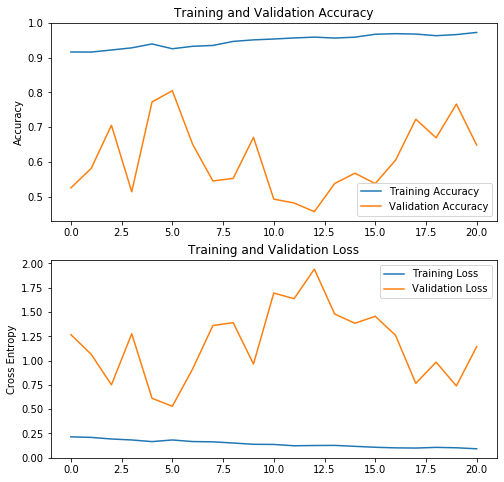

Training Acc:  [0.9163324575077332, 0.9160558705820514, 0.9220024893234716, 0.9282256949658447, 0.9394274651386022, 0.9255981192254473, 0.9326510856448657, 0.9351403679183007, 0.9467570184177588, 0.9511824090967796, 0.953671691345486, 0.9567141474620416, 0.9590651362520286, 0.9564375605363599, 0.9589268427685804, 0.9673627437669498, 0.9690222652633397, 0.9679159175853416, 0.9632139400136106, 0.966394689547671, 0.9726178951982871]



Evaluating model on test set...
Result on test set: 89.70%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.1812 - acc: 0.9267 - val_loss: 0.0782 - val_acc: 0.9751

Epoch 00001: val_loss improved from inf to 0.07824, saving model to checkpoints/GRAZ_sCNN__run_2.h5
Epoch 2/100
 - 47s - loss: 0.1702 - acc: 0.9368 - val_loss: 0.2149 - val_acc: 0.9353

Epoch 00002: val_loss did not improve from 0.07824
Epoch 3/100
 - 47s - loss: 0.1521 - acc: 0.9412 - val_loss: 0.9075 - val_acc: 0.6878

Epoch 00003: val_loss did not improve f

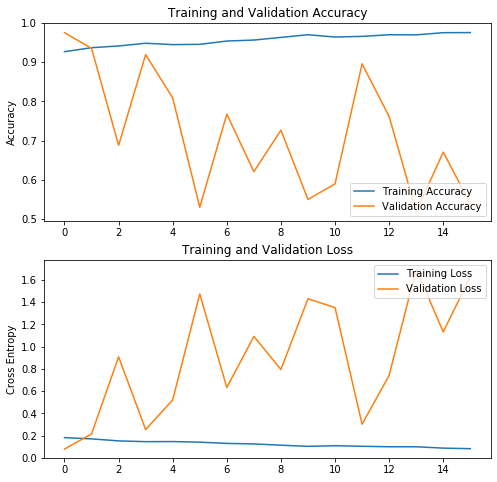

Training Acc:  [0.9267044669364172, 0.9367998894146906, 0.9412252800772256, 0.9481399530131958, 0.944682616512239, 0.9453740838388077, 0.9538099848289342, 0.9562992670529117, 0.9630756465631342, 0.9698520260238991, 0.964043700765927, 0.9657032222870457, 0.9698520259991702, 0.9695754390899743, 0.9751071774387504, 0.975383764389161]



Evaluating model on test set...
Result on test set: 71.13%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.1764 - acc: 0.9317 - val_loss: 0.1449 - val_acc: 0.9353

Epoch 00001: val_loss improved from inf to 0.14491, saving model to checkpoints/GRAZ_sCNN__run_3.h5
Epoch 2/100
 - 47s - loss: 0.1529 - acc: 0.9432 - val_loss: 0.1975 - val_acc: 0.9291

Epoch 00002: val_loss did not improve from 0.14491
Epoch 3/100
 - 47s - loss: 0.1530 - acc: 0.9466 - val_loss: 0.1945 - val_acc: 0.9316

Epoch 00003: val_loss did not improve from 0.14491
Epoch 4/100
 - 47s - loss: 0.1395 - acc: 0.9487 - val_loss: 0.5559 - val_acc: 0.7998

Epo

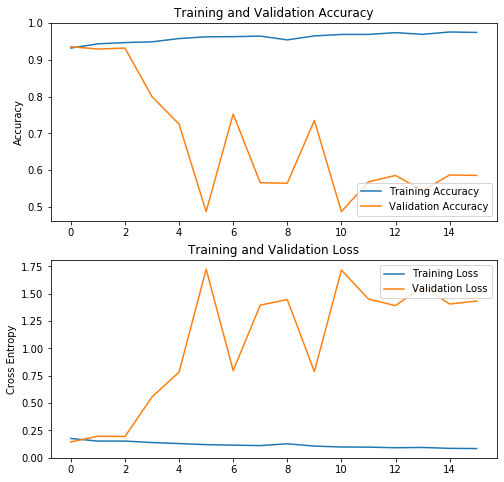

Training Acc:  [0.9316830314255868, 0.943161388532269, 0.9466187249755252, 0.9486931268398304, 0.9575439082143581, 0.9622458857696031, 0.9626607661704901, 0.9641819942328894, 0.9539482783041394, 0.9647351680347953, 0.9687456783459009, 0.9687456783541438, 0.973585949392837, 0.9690222652550967, 0.9753837643561892, 0.9741391232606864]



Evaluating model on test set...
Result on test set: 78.00%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.1607 - acc: 0.9376 - val_loss: 0.0756 - val_acc: 0.9701

Epoch 00001: val_loss improved from inf to 0.07556, saving model to checkpoints/GRAZ_sCNN__run_4.h5
Epoch 2/100
 - 46s - loss: 0.1430 - acc: 0.9483 - val_loss: 0.0840 - val_acc: 0.9639

Epoch 00002: val_loss did not improve from 0.07556
Epoch 3/100
 - 46s - loss: 0.1358 - acc: 0.9506 - val_loss: 0.2753 - val_acc: 0.9030

Epoch 00003: val_loss did not improve from 0.07556
Epoch 4/100
 - 47s - loss: 0.1427 - acc: 0.9436 - val_loss: 0.3310 - val_acc: 0.8893

Ep

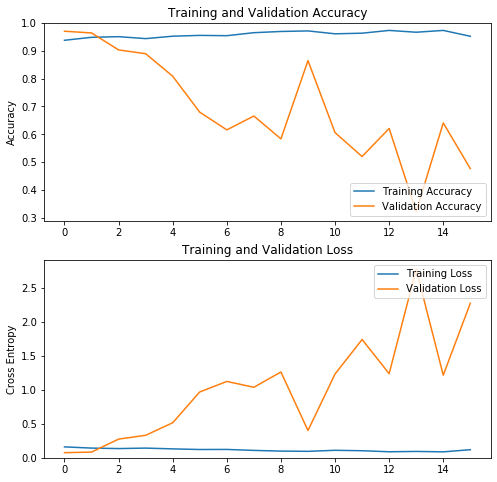

Training Acc:  [0.9376296501422783, 0.9482782464471864, 0.9506292353278455, 0.9435762688836984, 0.9522887567912637, 0.9551929193913994, 0.9540865717216442, 0.9648734615100005, 0.9692988521890215, 0.9712349606028501, 0.9608629512153808, 0.9630756465219195, 0.9730327755744453, 0.9665329829899045, 0.9730327756074171, 0.9520121698490961]



Evaluating model on test set...
Result on test set: 72.47%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.1567 - acc: 0.9407 - val_loss: 0.0324 - val_acc: 0.9851

Epoch 00001: val_loss improved from inf to 0.03242, saving model to checkpoints/GRAZ_sCNN__run_5.h5
Epoch 2/100
 - 47s - loss: 0.1363 - acc: 0.9509 - val_loss: 0.2013 - val_acc: 0.9254

Epoch 00002: val_loss did not improve from 0.03242
Epoch 3/100
 - 46s - loss: 0.1292 - acc: 0.9567 - val_loss: 1.0561 - val_acc: 0.6667

Epoch 00003: val_loss did not improve from 0.03242
Epoch 4/100
 - 47s - loss: 0.1258 - acc: 0.9555 - val_loss: 0.6201 - val_acc: 0.7923



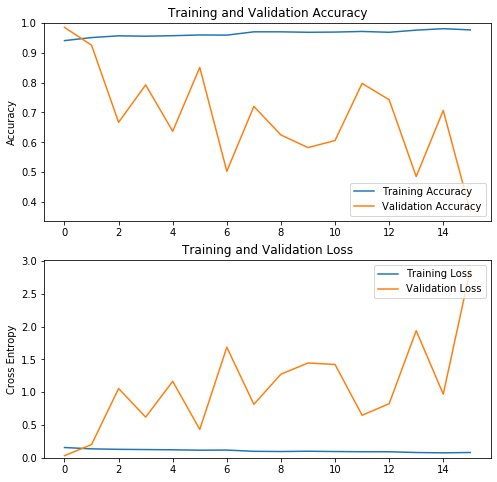

Training Acc:  [0.9406803097345132, 0.9509126106194691, 0.9567201327433629, 0.9554756637168141, 0.9571349557522124, 0.9596238938053098, 0.959070796460177, 0.9701327433628318, 0.9701327433628318, 0.9686117256637168, 0.9693030973451328, 0.9713772123893806, 0.9686117256637168, 0.9758019911504425, 0.980641592920354, 0.9766316371681416]



Evaluating model on test set...
Result on test set: 65.94%
75.45% (+/- 8.09%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores = []
history = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_sCNN_' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores.append(scores[1] * 100)
    ii += 1
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
train_acc = [0.9766316371681416, 0.9520121698490961,  0.9741391232606864, 0.975383764389161,  0.9726178951982871]

In [0]:
cap_df = pd.DataFrame(columns = ['Capacity (bits)', 'CV Train Acc', 'CV Test Acc'])
cap_df.loc['original sCNN', 'CV Test Acc'] = np.mean(cvscores)
cap_df.loc['original sCNN', 'Capacity (bits)'] = 8360
cap_df.loc['original sCNN', 'CV Train Acc'] = np.mean(train_acc)*100


In [0]:
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
original sCNN,8360,97.0157,75.4471


## our sCNN 2960 bits

In [0]:
###MODEL###

model = Sequential()
# Conv Block 1
model.add(Conv2D(input_shape=(3, 1000, 1), filters=20, kernel_size=(1, 25), strides=(1, 1),
                padding='valid', activation=None))
model.add(Reshape(target_shape=(3, 976, 20, 1)))
# model.add(Dropout(0.5))

# Conv Block 2
model.add(Conv3D(filters=20, kernel_size=(3, 1, 20), padding='valid',
                data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation(keras.backend.square))  # custom squaring activation function
model.add(Flatten())
model.add(Reshape(target_shape=(976, 20, 1)))
# model.add(Dropout(0.5))
# Pooling
model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
model.add(Activation(keras.backend.log))  # custom log function

# Classification
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

  # compile the model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 3, 976, 20)        520       
_________________________________________________________________
reshape_23 (Reshape)         (None, 3, 976, 20, 1)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 1, 976, 1, 20)     1220      
_________________________________________________________________
batch_normalization_8 (Batch (None, 1, 976, 1, 20)     80        
_________________________________________________________________
activation_22 (Activation)   (None, 1, 976, 1, 20)     0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 19520)             0         
_________________________________________________________________
reshape_24 (Reshape)         (None, 976, 20, 1)      

Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 28s - loss: 0.5780 - acc: 0.6916 - val_loss: 0.3481 - val_acc: 0.8669

Epoch 00001: val_loss improved from inf to 0.34811, saving model to checkpoints/GRAZ_sCNN_lowercap_run_1.h5
Epoch 2/100
 - 27s - loss: 0.3822 - acc: 0.8245 - val_loss: 0.9798 - val_acc: 0.4478

Epoch 00002: val_loss did not improve from 0.34811
Epoch 3/100
 - 27s - loss: 0.3319 - acc: 0.8549 - val_loss: 0.7795 - val_acc: 0.6070

Epoch 00003: val_loss did not improve from 0.34811
Epoch 4/100
 - 27s - loss: 0.3010 - acc: 0.8690 - val_loss: 0.3069 - val_acc: 0.8856

Epoch 00004: val_loss improved from 0.34811 to 0.30692, saving model to checkpoints/GRAZ_sCNN_lowercap_run_1.h5
Epoch 5/100
 - 27s - loss: 0.2718 - acc: 0.8899 - val_loss: 0.2041 - val_acc: 0.9328

Epoch 00005: val_loss improved from 0.30692 to 0.20413, saving model to checkpoints/GRAZ_sCNN_lowercap_run_1.h5
Epoch 6/100
 - 27s - loss: 0.2551 - acc: 0.8939 - val_loss: 0.1635 - val_acc: 0.

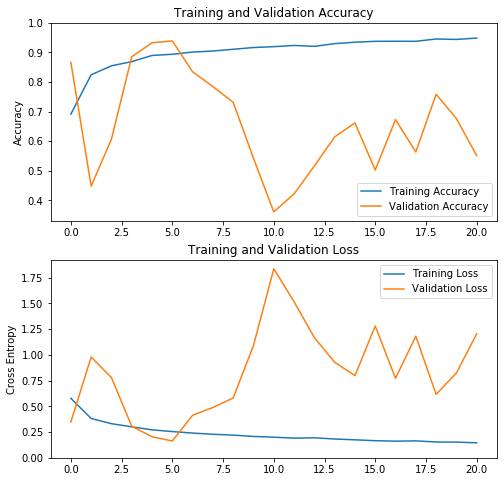

Training Acc:  [0.6916055871546475, 0.8245056009757504, 0.8549301618528043, 0.8690360946339404, 0.8899184069005702, 0.8939289172116758, 0.9013967639660377, 0.9049923939669285, 0.9108007191754429, 0.916747337933349, 0.9196515005169988, 0.923800304278581, 0.920757848194997, 0.9298852164539917, 0.9347254875091708, 0.9377679436504552, 0.9380445305019506, 0.9377679436009977, 0.9456506707727323, 0.9441294427103331, 0.9486931268398304]



Evaluating model on test set...
Result on test set: 80.79%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 27s - loss: 0.2453 - acc: 0.9015 - val_loss: 0.0306 - val_acc: 0.9913

Epoch 00001: val_loss improved from inf to 0.03062, saving model to checkpoints/GRAZ_sCNN_lowercap_run_2.h5
Epoch 2/100
 - 27s - loss: 0.2373 - acc: 0.9000 - val_loss: 0.1352 - val_acc: 0.9602

Epoch 00002: val_loss did not improve from 0.03062
Epoch 3/100
 - 27s - loss: 0.2221 - acc: 0.9119 - val_loss: 0.3271 - val_acc: 0.8731

Epoch 00003: val_loss did not im

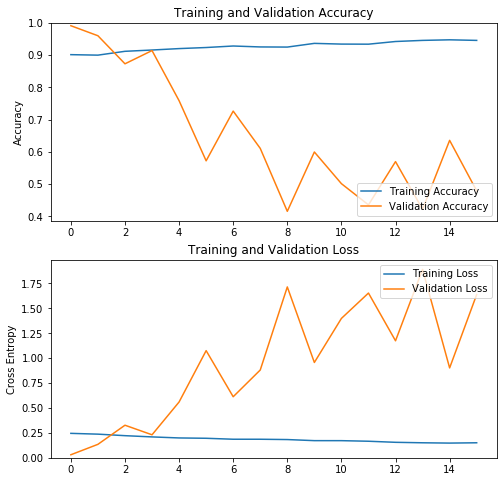

Training Acc:  [0.901535057433, 0.9000138294283012, 0.9119070668122264, 0.915917577131575, 0.9203429678353247, 0.9236620108528333, 0.9283639884163212, 0.9254598257914567, 0.9250449454235414, 0.9365233024972518, 0.9343106071577414, 0.9340340202485455, 0.9423316277222521, 0.94578896419848, 0.9475867791700753, 0.9457889642396947]



Evaluating model on test set...
Result on test set: 65.51%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 27s - loss: 0.2361 - acc: 0.9032 - val_loss: 0.0292 - val_acc: 0.9938

Epoch 00001: val_loss improved from inf to 0.02920, saving model to checkpoints/GRAZ_sCNN_lowercap_run_3.h5
Epoch 2/100
 - 27s - loss: 0.2296 - acc: 0.9075 - val_loss: 0.0801 - val_acc: 0.9677

Epoch 00002: val_loss did not improve from 0.02920
Epoch 3/100
 - 27s - loss: 0.2185 - acc: 0.9138 - val_loss: 0.0323 - val_acc: 0.9950

Epoch 00003: val_loss did not improve from 0.02920
Epoch 4/100
 - 27s - loss: 0.2159 - acc: 0.9130 - val_loss: 0.1648 - val_acc: 0.9341


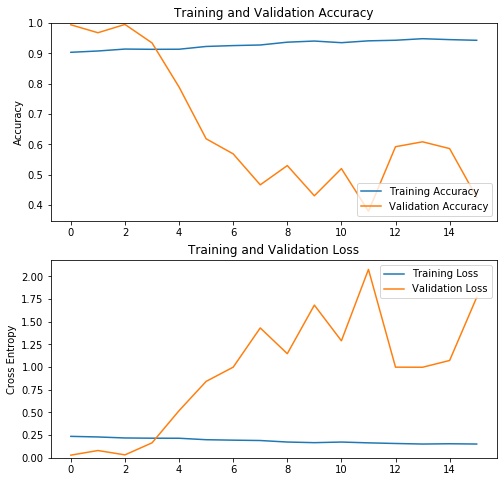

Training Acc:  [0.9031945789706046, 0.9074816761661773, 0.9138431752755127, 0.9130134145067105, 0.9132900014488781, 0.9224173697326016, 0.9253215323492231, 0.9272576407548089, 0.9365233024890088, 0.9402572258909186, 0.9348637809761331, 0.940948693151544, 0.9428848015736155, 0.9480016595379905, 0.9449592034873783, 0.9427465081066532]



Evaluating model on test set...
Result on test set: 65.60%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 27s - loss: 0.2320 - acc: 0.9050 - val_loss: 0.0581 - val_acc: 0.9764

Epoch 00001: val_loss improved from inf to 0.05809, saving model to checkpoints/GRAZ_sCNN_lowercap_run_4.h5
Epoch 2/100
 - 27s - loss: 0.2227 - acc: 0.9105 - val_loss: 0.0376 - val_acc: 0.9913

Epoch 00002: val_loss improved from 0.05809 to 0.03761, saving model to checkpoints/GRAZ_sCNN_lowercap_run_4.h5
Epoch 3/100
 - 27s - loss: 0.2181 - acc: 0.9084 - val_loss: 0.2226 - val_acc: 0.9129

Epoch 00003: val_loss did not improve from 0.03761
Epoch 4/100
 - 27s

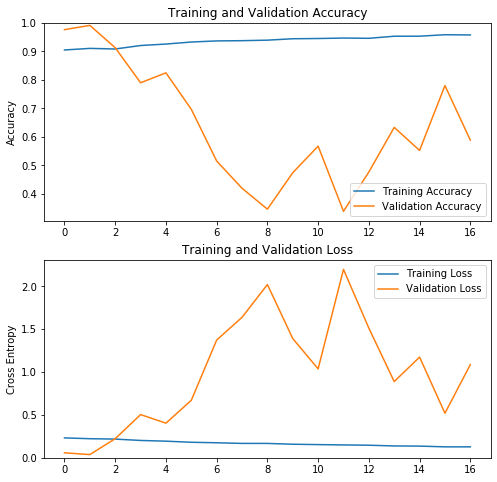

Training Acc:  [0.904992393917471, 0.9105241322497613, 0.9084497304184278, 0.9206195547115488, 0.9257364126759238, 0.9329276725293327, 0.9367998893982048, 0.9376296501422783, 0.9394274651303592, 0.9444060296112861, 0.9452357903718454, 0.9468953118599923, 0.9459272576736854, 0.9532568109693278, 0.9533951044198042, 0.958511962417151, 0.9578204950988252]



Evaluating model on test set...
Result on test set: 68.69%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 27s - loss: 0.2115 - acc: 0.9144 - val_loss: 0.3299 - val_acc: 0.8557

Epoch 00001: val_loss improved from inf to 0.32993, saving model to checkpoints/GRAZ_sCNN_lowercap_run_5.h5
Epoch 2/100
 - 27s - loss: 0.2047 - acc: 0.9168 - val_loss: 0.2213 - val_acc: 0.9005

Epoch 00002: val_loss improved from 0.32993 to 0.22131, saving model to checkpoints/GRAZ_sCNN_lowercap_run_5.h5
Epoch 3/100
 - 27s - loss: 0.1903 - acc: 0.9264 - val_loss: 0.2757 - val_acc: 0.8893

Epoch 00003: val_loss did not improve from 0.22131

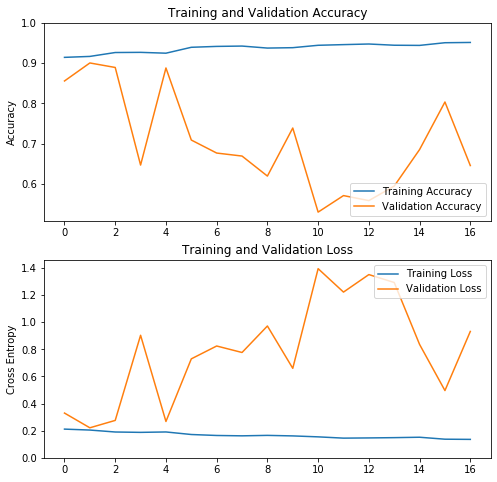

Training Acc:  [0.9144081858407079, 0.9167588495575221, 0.9264380530973452, 0.9268528761061947, 0.9247787610619469, 0.9394358407079646, 0.9416482300884956, 0.9424778761061947, 0.9375, 0.9384679203539823, 0.9444137168141593, 0.9460730088495575, 0.9475940265486725, 0.9445519911504425, 0.9441371681415929, 0.9507743362831859, 0.9514657079646017]



Evaluating model on test set...
Result on test set: 87.95%
73.71% (+/- 9.07%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_lowercap = []
history_lowercap = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_sCNN_lowercap' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_lowercap.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_lowercap.append(scores[1] * 100)
    ii += 1
    
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_lowercap), np.std(cvscores_lowercap)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
scnn_1_train = [0.9514657079646017,  0.9578204950988252, 0.942746508106653,  0.9457889642396947, 0.9486931268398304]

In [0]:
cap_df = pd.DataFrame(columns =['Capacity (bits)', 'CV Train Acc', 'CV Test Acc'] )

In [0]:
cap_df.loc['sCNN_og', 'CV Test Acc'] = 97.157
cap_df.loc['sCNN_og', 'Capacity (bits)'] = 8360
cap_df.loc['sCNN_og', 'CV Train Acc'] = 75.471

cap_df.loc['sCNN_1', 'CV Test Acc'] = np.mean(cvscores_lowercap)
cap_df.loc['sCNN_1', 'Capacity (bits)'] = 2960
cap_df.loc['sCNN_1', 'CV Train Acc'] = np.mean(scnn_1_train)*100


In [0]:
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
sCNN_og,8360,75.471,97.157
sCNN_1,2960,94.9303,73.7071


## our sCNN 1770 bits

In [0]:
###MODEL###

model = Sequential()
# Conv Block 1
model.add(Conv2D(input_shape=(3, 1000, 1), filters=15, kernel_size=(1, 25), strides=(1, 1),
                padding='valid', activation=None))
model.add(Reshape(target_shape=(3, 976, 15, 1)))
# model.add(Dropout(0.5))

# Conv Block 2
model.add(Conv3D(filters=15, kernel_size=(3, 1, 15), padding='valid',
                data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation(keras.backend.square))  # custom squaring activation function
model.add(Flatten())
model.add(Reshape(target_shape=(976, 15, 1)))
# model.add(Dropout(0.5))
# Pooling
model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
model.add(Activation(keras.backend.log))  # custom log function

# Classification
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

  # compile the model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 3, 976, 15)        390       
_________________________________________________________________
reshape_25 (Reshape)         (None, 3, 976, 15, 1)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 1, 976, 1, 15)     690       
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 976, 1, 15)     60        
_________________________________________________________________
activation_25 (Activation)   (None, 1, 976, 1, 15)     0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 14640)             0         
_________________________________________________________________
reshape_26 (Reshape)         (None, 976, 15, 1)      

Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 21s - loss: 0.2959 - acc: 0.8726 - val_loss: 0.0287 - val_acc: 0.9988

Epoch 00001: val_loss improved from inf to 0.02870, saving model to checkpoints/GRAZ_sCNN_2_run_1.h5
Epoch 2/100
 - 21s - loss: 0.2880 - acc: 0.8802 - val_loss: 0.0566 - val_acc: 0.9813

Epoch 00002: val_loss did not improve from 0.02870
Epoch 3/100
 - 22s - loss: 0.2648 - acc: 0.8934 - val_loss: 0.1002 - val_acc: 0.9701

Epoch 00003: val_loss did not improve from 0.02870
Epoch 4/100
 - 22s - loss: 0.2537 - acc: 0.8963 - val_loss: 0.2085 - val_acc: 0.9142

Epoch 00004: val_loss did not improve from 0.02870
Epoch 5/100
 - 22s - loss: 0.2519 - acc: 0.8988 - val_loss: 0.2278 - val_acc: 0.9055

Epoch 00005: val_loss did not improve from 0.02870
Epoch 6/100
 - 22s - loss: 0.2392 - acc: 0.9036 - val_loss: 0.4871 - val_acc: 0.7861

Epoch 00006: val_loss did not improve from 0.02870
Epoch 7/100
 - 22s - loss: 0.2317 - acc: 0.9087 - val_loss: 0.7549 - val

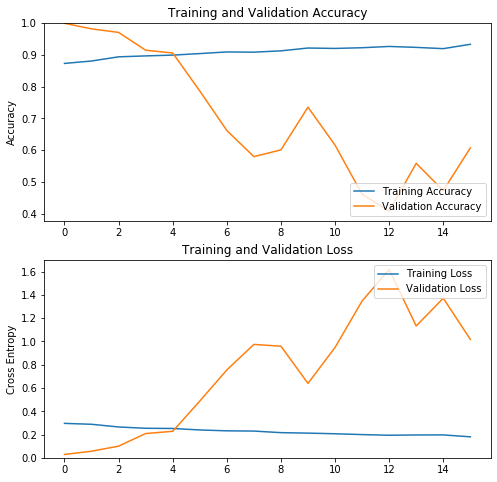

Training Acc:  [0.8726317246183454, 0.880237864790212, 0.8933757433932841, 0.8962799060263915, 0.8987691882915837, 0.9036094593714916, 0.9087263173028949, 0.9080348500010549, 0.9121836537131793, 0.9210344351454075, 0.9197897939592323, 0.9220024893152287, 0.9260129996345772, 0.9231088370097127, 0.9190983266738783, 0.9327893791200709]



Evaluating model on test set...
Result on test set: 61.52%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 22s - loss: 0.2870 - acc: 0.8815 - val_loss: 0.0527 - val_acc: 0.9826

Epoch 00001: val_loss improved from inf to 0.05269, saving model to checkpoints/GRAZ_sCNN_2_run_2.h5
Epoch 2/100
 - 22s - loss: 0.2757 - acc: 0.8867 - val_loss: 0.1129 - val_acc: 0.9652

Epoch 00002: val_loss did not improve from 0.05269
Epoch 3/100
 - 22s - loss: 0.2606 - acc: 0.8956 - val_loss: 0.1098 - val_acc: 0.9689

Epoch 00003: val_loss did not improve from 0.05269
Epoch 4/100
 - 22s - loss: 0.2473 - acc: 0.9011 - val_loss: 0.2016 - val_acc: 0.9341



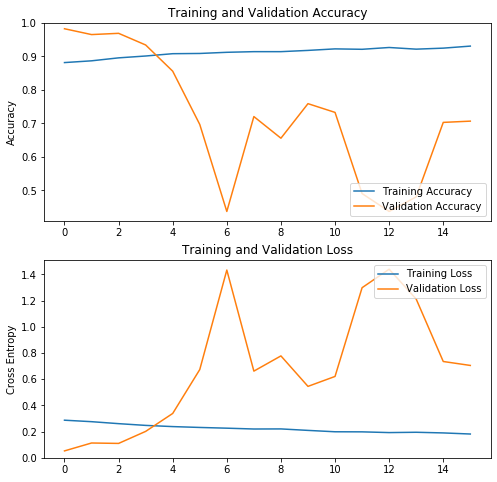

Training Acc:  [0.8814825059434155, 0.886737657350024, 0.8955884387080657, 0.9011201770568418, 0.9080348500175407, 0.9087263173111377, 0.9121836537708798, 0.9141197622094374, 0.9141197621847086, 0.9178536855454037, 0.9224173696831439, 0.9211727285629122, 0.926566173444726, 0.9215876090132569, 0.9246300650391402, 0.9307149772063081]



Evaluating model on test set...
Result on test set: 68.94%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 22s - loss: 0.2805 - acc: 0.8816 - val_loss: 0.1387 - val_acc: 0.9552

Epoch 00001: val_loss improved from inf to 0.13868, saving model to checkpoints/GRAZ_sCNN_2_run_3.h5
Epoch 2/100
 - 22s - loss: 0.2675 - acc: 0.8921 - val_loss: 0.1820 - val_acc: 0.9403

Epoch 00002: val_loss did not improve from 0.13868
Epoch 3/100
 - 22s - loss: 0.2561 - acc: 0.8923 - val_loss: 0.6734 - val_acc: 0.6816

Epoch 00003: val_loss did not improve from 0.13868
Epoch 4/100
 - 22s - loss: 0.2444 - acc: 0.8995 - val_loss: 0.7060 - val_acc: 0.6692

E

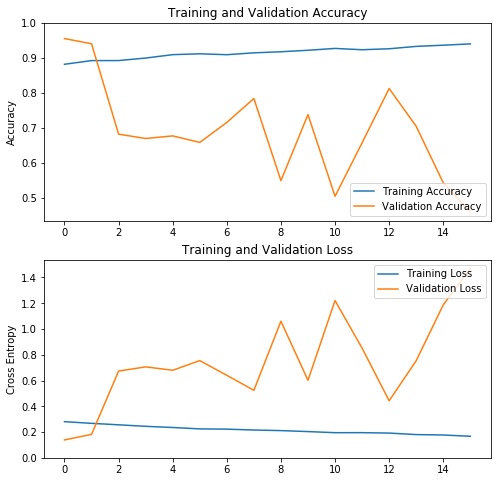

Training Acc:  [0.881620799385649, 0.8921311022648094, 0.8922693957235288, 0.8994606556016665, 0.9091411976460813, 0.9116304798865447, 0.9090029042285765, 0.9143963490939044, 0.9174388052022172, 0.9217259024390045, 0.9269810538126413, 0.9232471304601891, 0.9260129996098484, 0.9327893791200709, 0.9362467155715701, 0.9399806389405081]



Evaluating model on test set...
Result on test set: 79.49%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 22s - loss: 0.2701 - acc: 0.8913 - val_loss: 0.0396 - val_acc: 0.9863

Epoch 00001: val_loss improved from inf to 0.03957, saving model to checkpoints/GRAZ_sCNN_2_run_4.h5
Epoch 2/100
 - 22s - loss: 0.2553 - acc: 0.8955 - val_loss: 0.1692 - val_acc: 0.9391

Epoch 00002: val_loss did not improve from 0.03957
Epoch 3/100
 - 22s - loss: 0.2415 - acc: 0.9042 - val_loss: 0.4227 - val_acc: 0.8172

Epoch 00003: val_loss did not improve from 0.03957
Epoch 4/100
 - 22s - loss: 0.2367 - acc: 0.9086 - val_loss: 0.4338 - val_acc: 0.8197



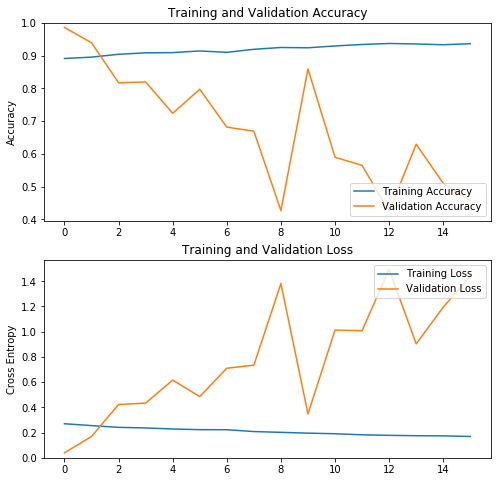

Training Acc:  [0.8913013415042501, 0.895450145282318, 0.9041626331486686, 0.9085880238606613, 0.9092794911130436, 0.9143963490774186, 0.9101092518818459, 0.91937491359956, 0.9249066519483361, 0.9240768912289914, 0.9296086295447958, 0.934172313699022, 0.9372147697743629, 0.9356935417284495, 0.9333425529714343, 0.9365233024560371]



Evaluating model on test set...
Result on test set: 66.50%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 22s - loss: 0.2615 - acc: 0.8924 - val_loss: 0.1887 - val_acc: 0.9303

Epoch 00001: val_loss improved from inf to 0.18868, saving model to checkpoints/GRAZ_sCNN_2_run_5.h5
Epoch 2/100
 - 22s - loss: 0.2437 - acc: 0.9033 - val_loss: 0.3624 - val_acc: 0.8557

Epoch 00002: val_loss did not improve from 0.18868
Epoch 3/100
 - 22s - loss: 0.2344 - acc: 0.9089 - val_loss: 0.4542 - val_acc: 0.8197

Epoch 00003: val_loss did not improve from 0.18868
Epoch 4/100
 - 22s - loss: 0.2342 - acc: 0.9082 - val_loss: 0.3051 - val_acc: 0.8818

Epo

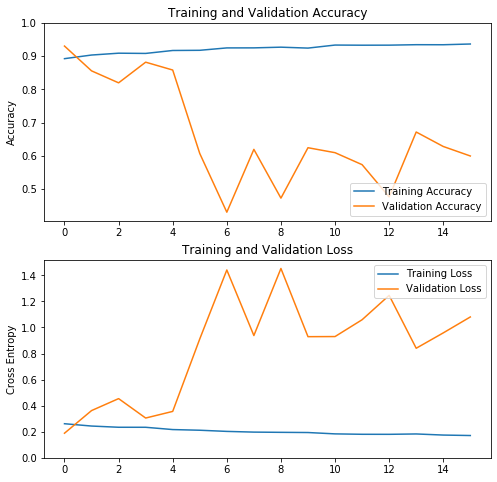

Training Acc:  [0.8924225663716814, 0.9033462389380531, 0.9088772123893806, 0.9081858407079646, 0.9170353982300885, 0.9175884955752213, 0.9247787610619469, 0.9249170353982301, 0.9269911504424779, 0.9242256637168141, 0.9333517699115044, 0.9329369469026548, 0.933075221238938, 0.9344579646017699, 0.9343196902654868, 0.9365320796460177]



Evaluating model on test set...
Result on test set: 80.58%
71.41% (+/- 7.45%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_2 = []
history_2 = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_sCNN_2' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_2.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_2.append(scores[1] * 100)
    ii += 1
    
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_2), np.std(cvscores_2)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
scnn_2_train = [0.9327893791200709, 0.9307149772063081, 0.9399806389405081, 0.9365233024560371, 0.936532079646017]

In [0]:

cap_df.loc['sCNN_og', 'CV Train Acc'] = 97.157
cap_df.loc['sCNN_og', 'CV Test Acc'] = 75.471
cap_df.loc['sCNN_2', 'CV Test Acc'] = np.mean(cvscores_2)
cap_df.loc['sCNN_2', 'Capacity (bits)'] = 1770
cap_df.loc['sCNN_2', 'CV Train Acc'] = np.mean(scnn_1_train)*100
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
sCNN_og,8360,97.157,75.471
sCNN_1,2960,94.9303,73.7071
sCNN_2,1770,94.9303,71.4067


## our sCNN 3388 bits

In [0]:
###MODEL###

model = Sequential()
# Conv Block 1
model.add(Conv2D(input_shape=(3, 1000, 1), filters=22, kernel_size=(1, 25), strides=(1, 1),
                padding='valid', activation=None))
model.add(Reshape(target_shape=(3, 976, 22, 1)))
# model.add(Dropout(0.5))

# Conv Block 2
model.add(Conv3D(filters=22, kernel_size=(3, 1, 22), padding='valid',
                data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation(keras.backend.square))  # custom squaring activation function
model.add(Flatten())
model.add(Reshape(target_shape=(976, 22, 1)))
# model.add(Dropout(0.5))
# Pooling
model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
model.add(Activation(keras.backend.log))  # custom log function

# Classification
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

  # compile the model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 3, 976, 22)        572       
_________________________________________________________________
reshape_43 (Reshape)         (None, 3, 976, 22, 1)     0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 1, 976, 1, 22)     1474      
_________________________________________________________________
batch_normalization_16 (Batc (None, 1, 976, 1, 22)     88        
_________________________________________________________________
activation_40 (Activation)   (None, 1, 976, 1, 22)     0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 21472)             0         
_________________________________________________________________
reshape_44 (Reshape)         (None, 976, 22, 1)      

Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 31s - loss: 0.5764 - acc: 0.6855 - val_loss: 0.2831 - val_acc: 0.8980

Epoch 00001: val_loss improved from inf to 0.28313, saving model to checkpoints/GRAZ_sCNN_0_run_1.h5
Epoch 2/100
 - 30s - loss: 0.3943 - acc: 0.8152 - val_loss: 0.8062 - val_acc: 0.5684

Epoch 00002: val_loss did not improve from 0.28313
Epoch 3/100
 - 30s - loss: 0.3428 - acc: 0.8475 - val_loss: 0.5750 - val_acc: 0.7450

Epoch 00003: val_loss did not improve from 0.28313
Epoch 4/100
 - 29s - loss: 0.3075 - acc: 0.8704 - val_loss: 0.6482 - val_acc: 0.7015

Epoch 00004: val_loss did not improve from 0.28313
Epoch 5/100
 - 29s - loss: 0.2866 - acc: 0.8801 - val_loss: 0.7276 - val_acc: 0.6667

Epoch 00005: val_loss did not improve from 0.28313
Epoch 6/100
 - 29s - loss: 0.2637 - acc: 0.8902 - val_loss: 0.7656 - val_acc: 0.6604

Epoch 00006: val_loss did not improve from 0.28313
Epoch 7/100
 - 29s - loss: 0.2436 - acc: 0.9002 - val_loss: 0.8177 - val

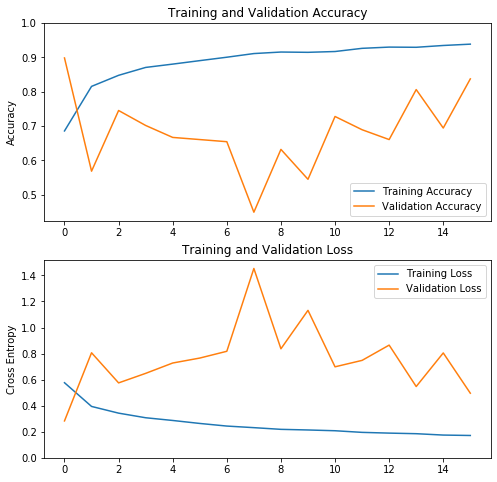

Training Acc:  [0.6855206749627508, 0.8152399392250645, 0.8474623151149283, 0.8704190292458632, 0.8800995713974361, 0.890194993818009, 0.9001521228293201, 0.9108007191507141, 0.9152261098297351, 0.9143963490691757, 0.9167473379086202, 0.9260129996180914, 0.9296086295365529, 0.9290554557099182, 0.9343106071412555, 0.938182823968913]



Evaluating model on test set...
Result on test set: 73.12%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 30s - loss: 0.4124 - acc: 0.8098 - val_loss: 0.1705 - val_acc: 0.9440

Epoch 00001: val_loss improved from inf to 0.17053, saving model to checkpoints/GRAZ_sCNN_0_run_2.h5
Epoch 2/100
 - 29s - loss: 0.3650 - acc: 0.8387 - val_loss: 0.1341 - val_acc: 0.9614

Epoch 00002: val_loss improved from 0.17053 to 0.13409, saving model to checkpoints/GRAZ_sCNN_0_run_2.h5
Epoch 3/100
 - 29s - loss: 0.3389 - acc: 0.8469 - val_loss: 0.4506 - val_acc: 0.8134

Epoch 00003: val_loss did not improve from 0.13409
Epoch 4/100
 - 29s - loss: 0.2995

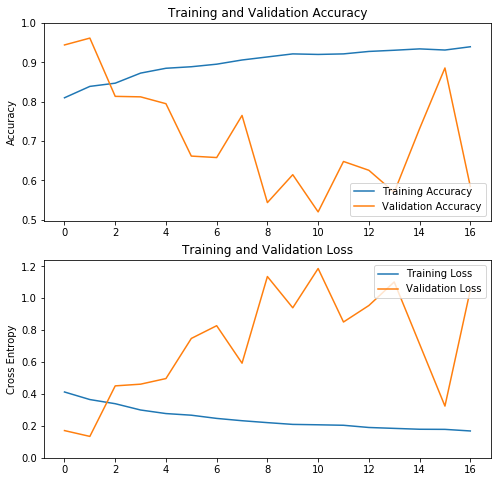

Training Acc:  [0.8098464944009514, 0.8387498272568206, 0.8469091412718077, 0.8724934311184114, 0.8848015489197094, 0.8886737657720956, 0.8951735583319075, 0.9058221546697873, 0.9135665883663169, 0.9213110220298746, 0.9199280874756524, 0.9213110220546034, 0.9275342276722477, 0.9305766838135322, 0.9340340202073308, 0.9311298575989522, 0.9394274650891447]



Evaluating model on test set...
Result on test set: 74.32%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 29s - loss: 0.3459 - acc: 0.8462 - val_loss: 1.1969 - val_acc: 0.4440

Epoch 00001: val_loss improved from inf to 1.19686, saving model to checkpoints/GRAZ_sCNN_0_run_3.h5
Epoch 2/100
 - 29s - loss: 0.3090 - acc: 0.8703 - val_loss: 0.2794 - val_acc: 0.9142

Epoch 00002: val_loss improved from 1.19686 to 0.27943, saving model to checkpoints/GRAZ_sCNN_0_run_3.h5
Epoch 3/100
 - 29s - loss: 0.2825 - acc: 0.8854 - val_loss: 0.8807 - val_acc: 0.5883

Epoch 00003: val_loss did not improve from 0.27943
Epoch 4/100

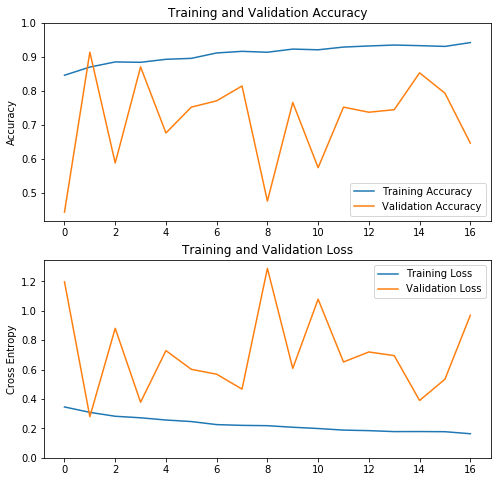

Training Acc:  [0.8462176739452391, 0.8702807358201156, 0.8853547227628299, 0.8842483751342893, 0.8930991564840882, 0.8958650256419904, 0.9117687733699928, 0.9164707509829384, 0.9138431752260552, 0.9231088370014697, 0.92103443509595, 0.929055455734647, 0.9322362052687074, 0.9350020744843102, 0.9332042594550144, 0.9309915641319898, 0.9421933342882615]



Evaluating model on test set...
Result on test set: 84.47%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 29s - loss: 0.2963 - acc: 0.8761 - val_loss: 0.3167 - val_acc: 0.9017

Epoch 00001: val_loss improved from inf to 0.31666, saving model to checkpoints/GRAZ_sCNN_0_run_4.h5
Epoch 2/100
 - 29s - loss: 0.2749 - acc: 0.8827 - val_loss: 0.3981 - val_acc: 0.8595

Epoch 00002: val_loss did not improve from 0.31666
Epoch 3/100
 - 29s - loss: 0.2621 - acc: 0.8906 - val_loss: 0.8725 - val_acc: 0.6405

Epoch 00003: val_loss did not improve from 0.31666
Epoch 4/100
 - 29s - loss: 0.2424 - acc: 0.9006 - val_loss: 0.7086 -

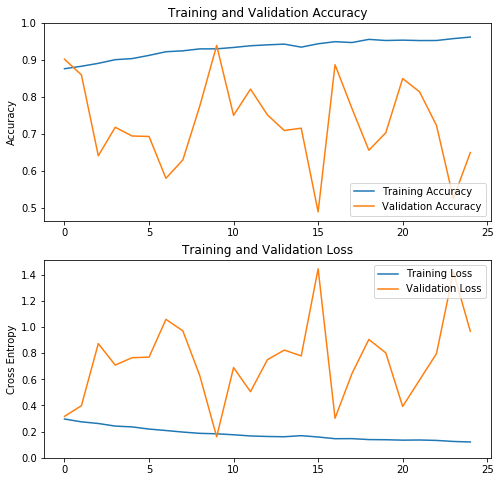

Training Acc:  [0.8760890610863304, 0.882727147080133, 0.890609874218896, 0.9005670032302071, 0.9034711658880434, 0.912183653754394, 0.9220024892987428, 0.9244917715556921, 0.9297469230117582, 0.9298852164869634, 0.9336191398559014, 0.9381828240018847, 0.940672106250591, 0.9426082146644197, 0.934448900591732, 0.9435762688672126, 0.9492463006911939, 0.9468953118682353, 0.9554695063005954, 0.9524270502417401, 0.9533951044198042, 0.9522887567582919, 0.9524270502087685, 0.9575439082061151, 0.9616927119512113]



Evaluating model on test set...
Result on test set: 80.54%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 29s - loss: 0.1893 - acc: 0.9289 - val_loss: 0.6635 - val_acc: 0.7400

Epoch 00001: val_loss improved from inf to 0.66346, saving model to checkpoints/GRAZ_sCNN_0_run_5.h5
Epoch 2/100
 - 29s - loss: 0.1792 - acc: 0.9307 - val_loss: 0.7536 - val_acc: 0.7475

Epoch 00002: val_loss did not improve from 0.66346
Epoch 3/100
 - 29s - loss: 0.1749 - acc: 0.9347

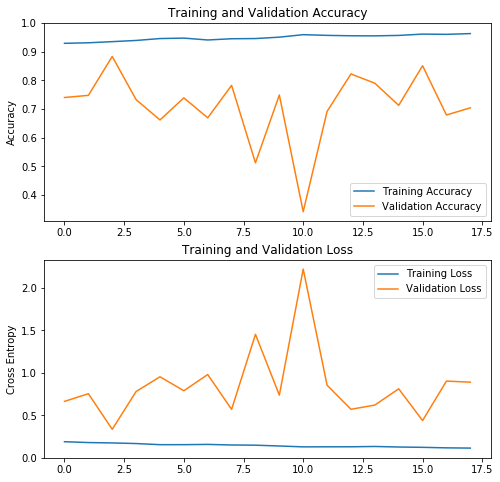

Training Acc:  [0.9289269911504425, 0.9307245575221239, 0.9347345132743363, 0.9388827433628318, 0.9455199115044248, 0.9470409292035398, 0.9405420353982301, 0.9448285398230089, 0.9455199115044248, 0.9503595132743363, 0.959070796460177, 0.9565818584070797, 0.9551991150442478, 0.9549225663716814, 0.9564435840707964, 0.9610066371681416, 0.9601769911504425, 0.962804203539823]



Evaluating model on test set...
Result on test set: 88.30%
80.15% (+/- 5.81%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_0 = []
history_0 = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_sCNN_0' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_0.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_0.append(scores[1] * 100)
    ii += 1
    
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_0), np.std(cvscores_0)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
scnn_0_train = [0.938182823968913, 0.9394274650891447,  0.9421933342882615, 0.9616927119512113, 0.962804203539823]

In [0]:

cap_df.loc['sCNN_0', 'CV Test Acc'] = np.mean(cvscores_0)
cap_df.loc['sCNN_0', 'Capacity (bits)'] = 3388
cap_df.loc['sCNN_0', 'CV Train Acc'] = np.mean(scnn_0_train)*100
cap_df.loc['sCNN_2', 'CV Train Acc'] = np.mean(scnn_2_train)*100

cap_df.sort_values('Capacity (bits)')

,Capacity (bits),CV Train Acc,CV Test Acc
sCNN_2,1770,93.5308,71.4067
sCNN_1,2960,94.9303,73.7071
sCNN_0,3388,94.886,80.1482
sCNN_og,8360,97.157,75.471


## our sCNN 3611 bits

In [0]:
###MODEL###

model = Sequential()
# Conv Block 1
model.add(Conv2D(input_shape=(3, 1000, 1), filters=23, kernel_size=(1, 25), strides=(1, 1),
                padding='valid', activation=None))
model.add(Reshape(target_shape=(3, 976, 23, 1)))
# model.add(Dropout(0.5))

# Conv Block 2
model.add(Conv3D(filters=23, kernel_size=(3, 1, 23), padding='valid',
                data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation(keras.backend.square))  # custom squaring activation function
model.add(Flatten())
model.add(Reshape(target_shape=(976, 23, 1)))
# model.add(Dropout(0.5))
# Pooling
model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
model.add(Activation(keras.backend.log))  # custom log function

# Classification
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

  # compile the model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 3, 976, 23)        598       
_________________________________________________________________
reshape_45 (Reshape)         (None, 3, 976, 23, 1)     0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 1, 976, 1, 23)     1610      
_________________________________________________________________
batch_normalization_17 (Batc (None, 1, 976, 1, 23)     92        
_________________________________________________________________
activation_43 (Activation)   (None, 1, 976, 1, 23)     0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 22448)             0         
_________________________________________________________________
reshape_46 (Reshape)         (None, 976, 23, 1)      

Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 31s - loss: 0.5876 - acc: 0.6768 - val_loss: 0.4295 - val_acc: 0.8085

Epoch 00001: val_loss improved from inf to 0.42954, saving model to checkpoints/GRAZ_sCNN_3_run_1.h5
Epoch 2/100
 - 30s - loss: 0.3940 - acc: 0.8249 - val_loss: 0.3573 - val_acc: 0.8632

Epoch 00002: val_loss improved from 0.42954 to 0.35734, saving model to checkpoints/GRAZ_sCNN_3_run_1.h5
Epoch 3/100
 - 30s - loss: 0.3353 - acc: 0.8571 - val_loss: 0.5531 - val_acc: 0.7264

Epoch 00003: val_loss did not improve from 0.35734
Epoch 4/100
 - 30s - loss: 0.3178 - acc: 0.8624 - val_loss: 0.8859 - val_acc: 0.5448

Epoch 00004: val_loss did not improve from 0.35734
Epoch 5/100
 - 31s - loss: 0.2859 - acc: 0.8798 - val_loss: 1.1542 - val_acc: 0.4527

Epoch 00005: val_loss did not improve from 0.35734
Epoch 6/100
 - 31s - loss: 0.2652 - acc: 0.8923 - val_loss: 1.5156 - val_acc: 0.3060

Epoch 00006: val_loss did not improve from 0.35734
Epoch 7/100
 - 30s

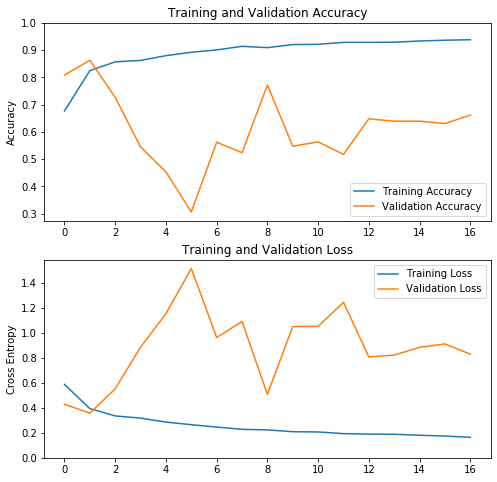

Training Acc:  [0.6768081870964002, 0.8249204813354227, 0.8571428572005577, 0.8623980086648667, 0.8798229844635114, 0.8922693957565005, 0.9008435901394031, 0.9141197621847086, 0.9092794911295295, 0.9204812612858011, 0.921449315488594, 0.9286405753502459, 0.9286405753502459, 0.9291937491933664, 0.9336191398806303, 0.9365233025302235, 0.9383211174523611]



Evaluating model on test set...
Result on test set: 82.23%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 31s - loss: 0.3451 - acc: 0.8571 - val_loss: 0.0251 - val_acc: 0.9988

Epoch 00001: val_loss improved from inf to 0.02511, saving model to checkpoints/GRAZ_sCNN_3_run_2.h5
Epoch 2/100
 - 31s - loss: 0.3144 - acc: 0.8714 - val_loss: 0.0382 - val_acc: 0.9950

Epoch 00002: val_loss did not improve from 0.02511
Epoch 3/100
 - 31s - loss: 0.2995 - acc: 0.8721 - val_loss: 0.0448 - val_acc: 0.9925

Epoch 00003: val_loss did not improve from 0.02511
Epoch 4/100
 - 31s - loss: 0.2782 - acc: 0.8866 - val_loss: 1.0249

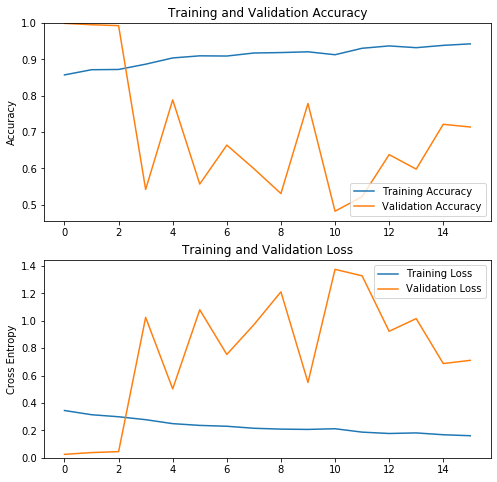

Training Acc:  [0.8571428572170435, 0.8713870834239273, 0.8720785507010385, 0.8865993639325193, 0.9037477528054823, 0.9095560780552112, 0.9090029042368195, 0.917300511718769, 0.9185451528472436, 0.9206195547939782, 0.912598534163524, 0.9303000968631217, 0.9367998893982048, 0.9319596183595116, 0.9383211174441182, 0.9424699211974573]



Evaluating model on test set...
Result on test set: 59.68%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 31s - loss: 0.3174 - acc: 0.8675 - val_loss: 0.0295 - val_acc: 0.9975

Epoch 00001: val_loss improved from inf to 0.02952, saving model to checkpoints/GRAZ_sCNN_3_run_3.h5
Epoch 2/100
 - 31s - loss: 0.2942 - acc: 0.8750 - val_loss: 0.2394 - val_acc: 0.9030

Epoch 00002: val_loss did not improve from 0.02952
Epoch 3/100
 - 31s - loss: 0.2680 - acc: 0.8927 - val_loss: 0.5068 - val_acc: 0.7774

Epoch 00003: val_loss did not improve from 0.02952
Epoch 4/100
 - 31s - loss: 0.2566 - acc: 0.8977 - val_loss: 0.4453 - val_acc: 0.8134

E

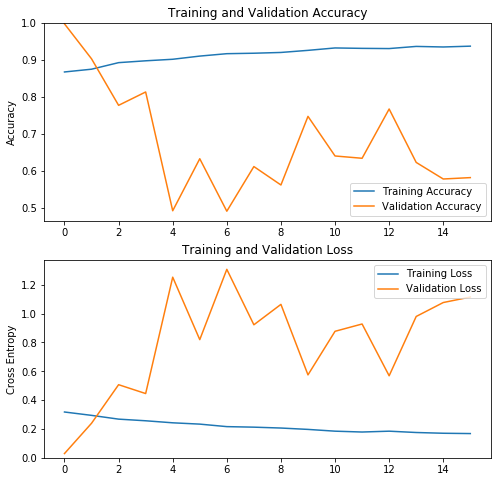

Training Acc:  [0.8675148666374846, 0.8749827133671176, 0.8926842760667153, 0.8976628405641279, 0.9018116443669247, 0.910385838766313, 0.9168856313673396, 0.9181302724793283, 0.9202046743353905, 0.925874706151129, 0.9323744987686414, 0.9312681510659145, 0.9307149772063081, 0.936523302480766, 0.9350020744595813, 0.9372147697578771]



Evaluating model on test set...
Result on test set: 63.41%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 31s - loss: 0.3006 - acc: 0.8721 - val_loss: 0.0344 - val_acc: 0.9913

Epoch 00001: val_loss improved from inf to 0.03440, saving model to checkpoints/GRAZ_sCNN_3_run_4.h5
Epoch 2/100
 - 31s - loss: 0.2911 - acc: 0.8775 - val_loss: 0.1430 - val_acc: 0.9490

Epoch 00002: val_loss did not improve from 0.03440
Epoch 3/100
 - 31s - loss: 0.2577 - acc: 0.8931 - val_loss: 1.0463 - val_acc: 0.5311

Epoch 00003: val_loss did not improve from 0.03440
Epoch 4/100
 - 31s - loss: 0.2391 - acc: 0.9025 - val_loss: 0.9123 - val_acc: 0.5846

Ep

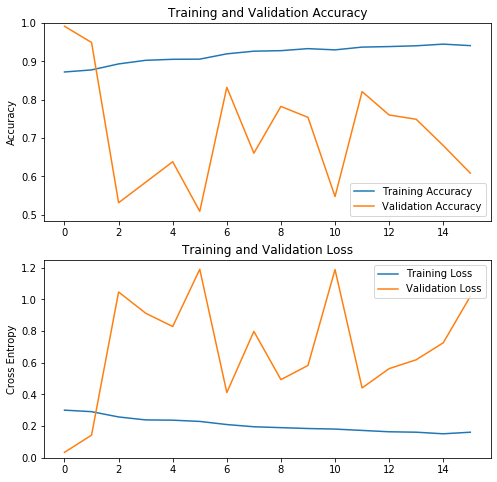

Training Acc:  [0.8720785507917107, 0.8774719955993381, 0.893099156508817, 0.9025031116522788, 0.9051306873926762, 0.9055455677770774, 0.9193749136160458, 0.9262895865437731, 0.9276725210979954, 0.9329276725787903, 0.9297469229787865, 0.9369381828321953, 0.9383211174606041, 0.9403955193331521, 0.9446826165699395, 0.9408103997010674]



Evaluating model on test set...
Result on test set: 63.86%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 31s - loss: 0.2785 - acc: 0.8938 - val_loss: 0.4119 - val_acc: 0.8147

Epoch 00001: val_loss improved from inf to 0.41186, saving model to checkpoints/GRAZ_sCNN_3_run_5.h5
Epoch 2/100
 - 31s - loss: 0.2584 - acc: 0.8966 - val_loss: 0.5947 - val_acc: 0.7388

Epoch 00002: val_loss did not improve from 0.41186
Epoch 3/100
 - 31s - loss: 0.2385 - acc: 0.9060 - val_loss: 0.3017 - val_acc: 0.8694

Epoch 00003: val_loss improved from 0.41186 to 0.30169, saving model to checkpoints/GRAZ_sCNN_3_run_5.h5
Epoch 4/100
 - 30s - loss: 0.227

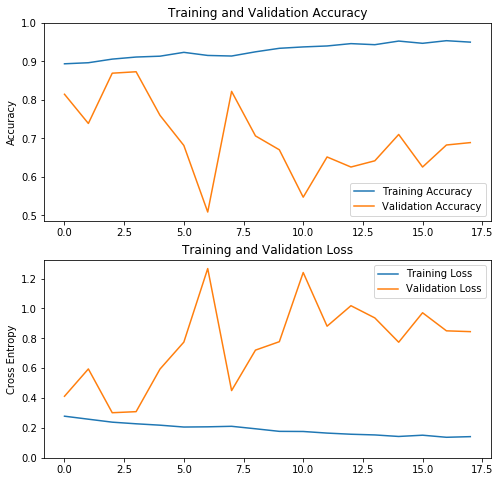

Training Acc:  [0.8938053097345132, 0.896570796460177, 0.9059734513274337, 0.9113661504424779, 0.9135785398230089, 0.9235342920353983, 0.9155143805309734, 0.9139933628318584, 0.9249170353982301, 0.9340431415929203, 0.9376382743362832, 0.9401272123893806, 0.9462112831858407, 0.943445796460177, 0.9528484513274337, 0.9470409292035398, 0.953816371681416, 0.9500829646017699]



Evaluating model on test set...
Result on test set: 86.55%
71.15% (+/- 11.00%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_3 = []
history_3 = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_sCNN_3' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_3.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_3.append(scores[1] * 100)
    ii += 1
    
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_3), np.std(cvscores_3)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
scnn_train_3 = [0.9500829646017699, 0.9408103997010674, 0.9372147697578771, 0.9424699211974573, 0.9383211174523611]

In [0]:
cvscores_3 = [82.23, 59.68, 63.41, 63.86, 86.55]

In [0]:
import pandas as pd
import numpy as np

In [0]:
cap_df = pd.DataFrame(columns=['Capacity (bits)', 'CV Train Acc', 'CV Test Acc'])

In [0]:
cap_df.loc['sCNN_og', 'Capacity (bits)'] = 8630
cap_df.loc['sCNN_og', 'CV Train Acc'] = 97.157
cap_df.loc['sCNN_og', 'CV Test Acc'] = 75.471

cap_df.loc['sCNN_1', 'Capacity (bits)'] = 3611
cap_df.loc['sCNN_1', 'CV Train Acc'] = 94.178
cap_df.loc['sCNN_1', 'CV Test Acc'] =71.146

cap_df.loc['sCNN_2', 'Capacity (bits)'] = 3388
cap_df.loc['sCNN_2', 'CV Train Acc'] = 94.886
cap_df.loc['sCNN_2', 'CV Test Acc'] = 80.1482

cap_df.loc['sCNN_3', 'Capacity (bits)'] = 2960
cap_df.loc['sCNN_3', 'CV Train Acc'] = 94.9303
cap_df.loc['sCNN_3', 'CV Test Acc'] = 73.7071

cap_df.loc['sCNN_4', 'Capacity (bits)'] = 1770
cap_df.loc['sCNN_4', 'CV Train Acc'] = 93.5308
cap_df.loc['sCNN_4', 'CV Test Acc'] = 71.4067

In [0]:
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
sCNN_og,8630,97.157,75.471
sCNN_1,3611,94.178,71.146
sCNN_2,3388,94.886,80.1482
sCNN_3,2960,94.9303,73.7071
sCNN_4,1770,93.5308,71.4067


## Graphs

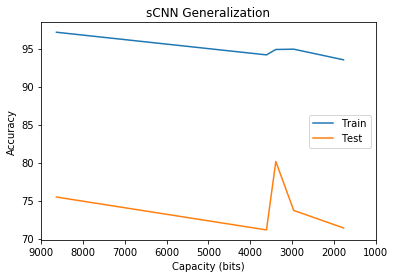

In [0]:
plt.plot(cap_df['Capacity (bits)'], cap_df['CV Train Acc'], label = 'Train')
plt.plot(cap_df['Capacity (bits)'], cap_df['CV Test Acc'], label = 'Test')
plt.xlim(9000, 1000)
plt.xlabel('Capacity (bits)')
plt.ylabel('Accuracy')
plt.title('sCNN Generalization')
plt.legend()

# pCNN

In [0]:
x_subject = x_augmented
y_subject = y_augmented
x_subject = np.rollaxis(x_subject, 2, 1)
# x_subject = np.rollaxis(x_subject, 1)
# x_subject = np.rollaxis(x_subject, 2, 1)
x_subject.shape

(10044, 3, 1000)

In [0]:
import keras
from kapre.time_frequency import Spectrogram
from kapre.utils import Normalization2D

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import BatchNormalization, Dropout, Conv2D, MaxPooling2D


## og pCNN

In [0]:
input_shape = x_subject.shape[1:]
model = Sequential()

# spectrogram creation using STFT
model.add(Spectrogram(n_dft = 128, n_hop = 16, input_shape = input_shape,
        return_decibel_spectrogram = False, power_spectrogram = 2.0,
        trainable_kernel = False, name = 'static_stft'))
model.add(Normalization2D(str_axis = 'freq'))

# Conv Block 1
model.add(Conv2D(filters = 24, kernel_size = (12, 12),
                strides = (1, 1), name = 'conv1',
                border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2), padding = 'valid',
                      data_format = 'channels_last'))

# Conv Block 2
model.add(Conv2D(filters = 48, kernel_size = (8, 8),
                name = 'conv2', border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid',
                      data_format = 'channels_last'))

# Conv Block 3
model.add(Conv2D(filters = 96, kernel_size = (4, 4),
                name = 'conv3', border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2),
                      padding = 'valid',
                      data_format = 'channels_last'))
# model.add(Dropout(dropout))

# classificator
model.add(Flatten())
model.add(Dense(2))  # two classes only
model.add(Activation('softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=24, kernel_size=(12, 12), strides=(1, 1), name="conv1", padding="same")`
  del sys.path[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=48, kernel_size=(8, 8), name="conv2", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=96, kernel_size=(4, 4), name="conv3", padding="same")`


In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
static_stft (Spectrogram)    (None, 65, 63, 3)         16640     
_________________________________________________________________
normalization2d_1 (Normaliza (None, 65, 63, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 65, 63, 24)        10392     
_________________________________________________________________
batch_normalization_1 (Batch (None, 65, 63, 24)        260       
_________________________________________________________________
activation_1 (Activation)    (None, 65, 63, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 24)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 31, 48)       

Run 1...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 243s - loss: 1.0368 - acc: 0.5403 - val_loss: 0.7989 - val_acc: 0.3669

Epoch 00001: val_loss improved from inf to 0.79889, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 2/100
 - 244s - loss: 0.6621 - acc: 0.6014 - val_loss: 0.5607 - val_acc: 0.7898

Epoch 00002: val_loss improved from 0.79889 to 0.56069, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 3/100
 - 243s - loss: 0.6451 - acc: 0.6262 - val_loss: 0.3736 - val_acc: 0.9801

Epoch 00003: val_loss improved from 0.56069 to 0.37364, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 4/100
 - 244s - loss: 0.6224 - acc: 0.6541 - val_loss: 0.5740 - val_acc: 0.7624

Epoch 00004: val_loss did not improve from 0.37364
Epoch 5/100
 - 244s - loss: 0.5505 - acc: 0.7229 - val_loss: 0.6775 - val_acc: 0.5858

Epoch 00005: val_loss did not improve from 0.37364
Epo

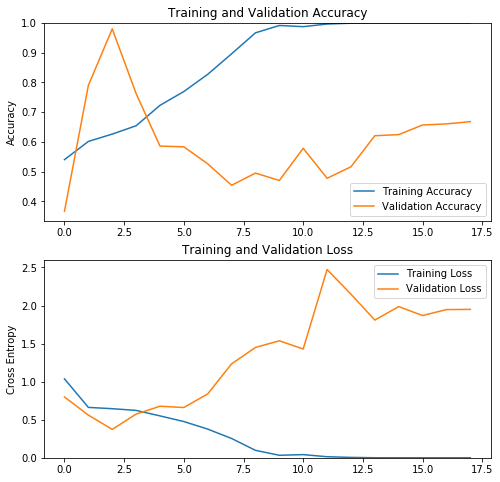

Training Acc:  [0.5403125434310221, 0.6014382521685122, 0.6261927812710423, 0.654128059874661, 0.7228599088252324, 0.7693265109549517, 0.8271331766831761, 0.8961416125264575, 0.9666712764651099, 0.9914258055593971, 0.9874152952647773, 0.9962660766145761, 0.9990319457889641, 1.0, 1.0, 1.0, 1.0, 1.0]



Evaluating model on test set...
Result on test set: 53.31%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 245s - loss: 0.6448 - acc: 0.6410 - val_loss: 0.3451 - val_acc: 0.8930

Epoch 00001: val_loss improved from inf to 0.34505, saving model to checkpoints/GRAZ_pCNN__run_2.h5
Epoch 2/100
 - 247s - loss: 0.5801 - acc: 0.6916 - val_loss: 0.7217 - val_acc: 0.5522

Epoch 00002: val_loss did not improve from 0.34505
Epoch 3/100
 - 244s - loss: 0.4819 - acc: 0.7682 - val_loss: 0.8426 - val_acc: 0.4254

Epoch 00003: val_loss did not improve from 0.34505
Epoch 4/100
 - 244s - loss: 0.3975 - acc: 0.8219 - val_loss: 1.0226 - val_acc: 0.4129

Epoch 00004: val_loss did not im

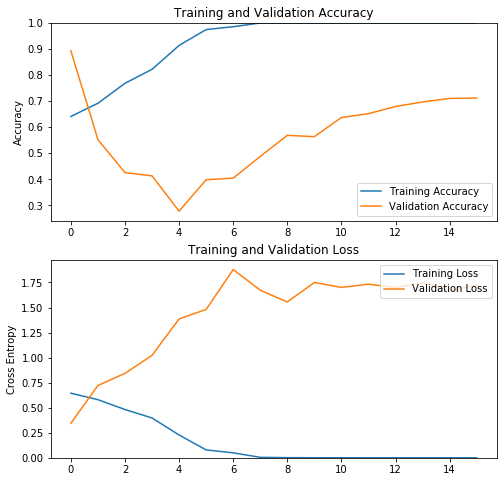

Training Acc:  [0.6409901813787472, 0.6916055871958621, 0.768220163334654, 0.8218780252683247, 0.9135665883168592, 0.9744157101616393, 0.9854791868344628, 0.9997234130825612, 0.9998617065412806, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Evaluating model on test set...
Result on test set: 57.44%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 246s - loss: 0.5801 - acc: 0.6902 - val_loss: 1.9757 - val_acc: 0.1032

Epoch 00001: val_loss improved from inf to 1.97573, saving model to checkpoints/GRAZ_pCNN__run_3.h5
Epoch 2/100
 - 244s - loss: 0.5368 - acc: 0.7305 - val_loss: 0.6351 - val_acc: 0.6231

Epoch 00002: val_loss improved from 1.97573 to 0.63508, saving model to checkpoints/GRAZ_pCNN__run_3.h5
Epoch 3/100
 - 246s - loss: 0.3941 - acc: 0.8233 - val_loss: 1.3296 - val_acc: 0.2873

Epoch 00003: val_loss did not improve from 0.63508
Epoch 4/100
 - 246s - loss: 0.2760 - acc: 0.8834 - val_loss: 1.9563 - val_acc: 0.2388

Epoch 00004: val_loss did not improve from 0.6350

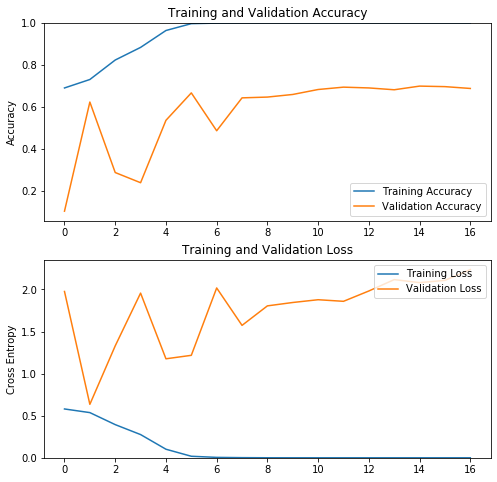

Training Acc:  [0.6902226526004251, 0.7304660490960142, 0.8232609598637617, 0.8834186142995436, 0.9639054072824789, 0.9965426635320149, 0.9990319457889641, 0.9998617065412806, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Evaluating model on test set...
Result on test set: 75.01%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 245s - loss: 0.4126 - acc: 0.8140 - val_loss: 0.3014 - val_acc: 0.8694

Epoch 00001: val_loss improved from inf to 0.30138, saving model to checkpoints/GRAZ_pCNN__run_4.h5
Epoch 2/100
 - 245s - loss: 0.2911 - acc: 0.8757 - val_loss: 0.6864 - val_acc: 0.6542

Epoch 00002: val_loss did not improve from 0.30138
Epoch 3/100
 - 248s - loss: 0.1092 - acc: 0.9634 - val_loss: 0.7844 - val_acc: 0.6928

Epoch 00003: val_loss did not improve from 0.30138
Epoch 4/100
 - 247s - loss: 0.0501 - acc: 0.9835 - val_loss: 0.6476 - val_acc: 0.7948

Epoch 00004: val_loss did not improve from 0.30138
Epoch 5/100
 - 247s - loss: 0.0077 - acc: 0.9986 - val_loss:

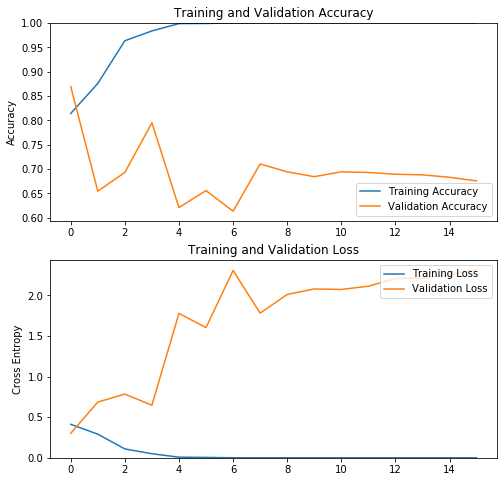

Training Acc:  [0.813995298088347, 0.8756741806936864, 0.9633522334476012, 0.9835430784123911, 0.9986170654128059, 0.9988936523302447, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Evaluating model on test set...
Result on test set: 71.78%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 248s - loss: 0.3685 - acc: 0.8309 - val_loss: 1.1259 - val_acc: 0.5211

Epoch 00001: val_loss improved from inf to 1.12587, saving model to checkpoints/GRAZ_pCNN__run_5.h5
Epoch 2/100
 - 248s - loss: 0.1551 - acc: 0.9369 - val_loss: 0.4545 - val_acc: 0.8097

Epoch 00002: val_loss improved from 1.12587 to 0.45450, saving model to checkpoints/GRAZ_pCNN__run_5.h5
Epoch 3/100
 - 248s - loss: 0.0407 - acc: 0.9881 - val_loss: 1.0827 - val_acc: 0.7127

Epoch 00003: val_loss did not improve from 0.45450
Epoch 4/100
 - 245s - loss: 0.0038 - acc: 0.9994 - val_loss: 2.1314 - val_acc: 0.5659

Epoch 00004: val_loss did not improve from 0.45450
Epoch 5/100
 - 245s - loss: 0.0012 - acc: 1

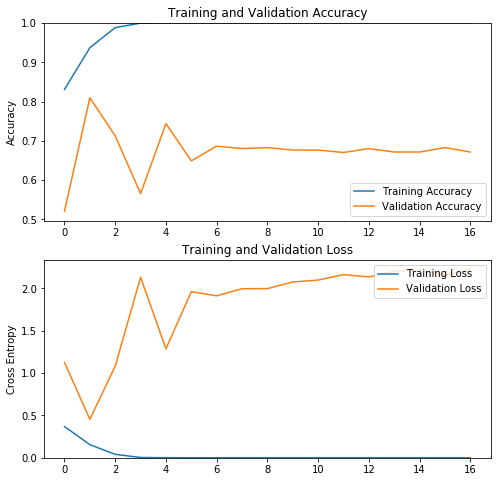

Training Acc:  [0.8308904867256637, 0.9369469026548672, 0.988108407079646, 0.9994469026548672, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Evaluating model on test set...
Result on test set: 83.72%
68.25% (+/- 11.29%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores = []
history = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_pCNN_' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores.append(scores[1] * 100)
    ii += 1
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
pcnn_train_acc = [1, 1, 1, 1, 1]
cvscores = [53.31, 57.44, 75.01, 71.78, 83.72]

In [0]:
cap_df = pd.DataFrame(columns = ['Capacity (bits)', 'CV Train Acc', 'CV Test Acc'])
cap_df.loc['pCNN_og', 'CV Test Acc'] = np.mean(cvscores)
cap_df.loc['pCNN_og', 'Capacity (bits)'] = 53192
cap_df.loc['pCNN_og', 'CV Train Acc'] = np.mean(pcnn_train_acc)*100


In [0]:
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
pCNN_og,53192,100,68.252


## our pCNN  3670 bits

In [0]:
input_shape = x_subject.shape[1:]
model = Sequential()

# spectrogram creation using STFT
model.add(Spectrogram(n_dft = 32, n_hop = 16, input_shape = input_shape,
        return_decibel_spectrogram = False, power_spectrogram = 2.0,
        trainable_kernel = False, name = 'static_stft'))
model.add(Normalization2D(str_axis = 'freq'))

# Conv Block 1
model.add(Conv2D(filters = 20,  kernel_size = (4, 4),
                strides = (1, 1), name = 'conv1',
                border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2), padding = 'valid',
                      data_format = 'channels_last'))

# Conv Block 2
model.add(Conv2D(filters = 12, kernel_size = (2, 2),
                name = 'conv2', border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid',
                      data_format = 'channels_last'))


# # Conv Block 3
model.add(Conv2D(filters = 10, kernel_size = (2, 2),
                name = 'conv3', border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2),
                      padding = 'valid',
                      data_format = 'channels_last'))
# model.add(Dropout(dropout))
model.summary()

# classificator
model.add(Flatten())
model.add(Dense(2))  # two classes only
model.add(Activation('softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=20, kernel_size=(4, 4), strides=(1, 1), name="conv1", padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=12, kernel_size=(2, 2), name="conv2", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=10, kernel_size=(2, 2), name="conv3", padding="same")`


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
static_stft (Spectrogram)    (None, 17, 63, 3)         1088      
_________________________________________________________________
normalization2d_25 (Normaliz (None, 17, 63, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 17, 63, 20)        980       
_________________________________________________________________
batch_normalization_54 (Batc (None, 17, 63, 20)        68        
_________________________________________________________________
activation_61 (Activation)   (None, 17, 63, 20)        0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 8, 31, 20)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 31, 12)       

Run 1...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 15s - loss: 0.7080 - acc: 0.5405 - val_loss: 0.8229 - val_acc: 0.2998

Epoch 00001: val_loss improved from inf to 0.82292, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 2/100
 - 10s - loss: 0.6677 - acc: 0.5876 - val_loss: 0.8815 - val_acc: 0.1841

Epoch 00002: val_loss did not improve from 0.82292
Epoch 3/100
 - 10s - loss: 0.6439 - acc: 0.6338 - val_loss: 0.6927 - val_acc: 0.5398

Epoch 00003: val_loss improved from 0.82292 to 0.69270, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 4/100
 - 10s - loss: 0.6069 - acc: 0.6804 - val_loss: 0.6190 - val_acc: 0.6853

Epoch 00004: val_loss improved from 0.69270 to 0.61901, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 5/100
 - 10s - loss: 0.5498 - acc: 0.7295 - val_loss: 0.4953 - val_acc: 0.8234

Epoch 00005: val_loss improved from 0.61901 to 0.49530, sav

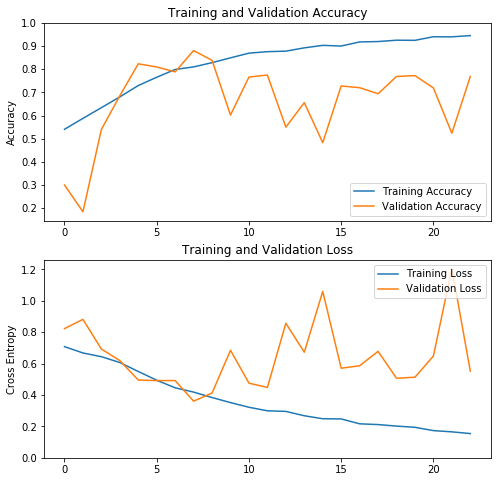

Training Acc:  [0.5404508368732557, 0.5876089062965719, 0.633798921442909, 0.6804038170725623, 0.7294979949014643, 0.7653160006768178, 0.7989213111538755, 0.8099847878184561, 0.8283778178363795, 0.8491218365948323, 0.8694509750513133, 0.8758124741111911, 0.8780251694424587, 0.8922693956905571, 0.9030562854953993, 0.9001521228293201, 0.9178536855536465, 0.9195132070912512, 0.9253215323244943, 0.9247683585225884, 0.940257225849704, 0.9398423454900316, 0.9452357904048171]



Evaluating model on test set...
Result on test set: 73.07%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 10s - loss: 0.4025 - acc: 0.8163 - val_loss: 0.4900 - val_acc: 0.7649

Epoch 00001: val_loss improved from inf to 0.49003, saving model to checkpoints/GRAZ_pCNN__run_2.h5
Epoch 2/100
 - 10s - loss: 0.3786 - acc: 0.8367 - val_loss: 0.6154 - val_acc: 0.6878

Epoch 00002: val_loss did not improve from 0.49003
Epoch 3/100
 - 10s - loss: 0.3583 - acc: 0.8465 - val_loss: 0.6173 - val_acc: 0.6791


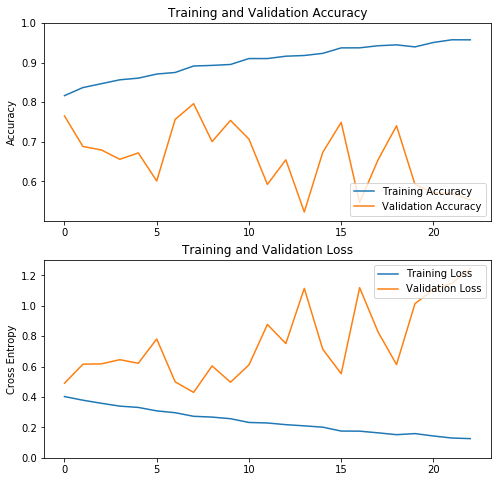

Training Acc:  [0.8163462869195486, 0.8366754253430578, 0.8464942608874066, 0.856313096481213, 0.8604619001933375, 0.8708339096137785, 0.8748444198919124, 0.8911630480455307, 0.89268427610793, 0.8950352648567023, 0.9099709584148836, 0.9099709584396124, 0.9159175771810326, 0.9177153921114131, 0.9231088369849839, 0.93693818287341, 0.9370764762909147, 0.942331627730495, 0.9445443231029772, 0.9394274651303592, 0.9506292352454162, 0.9574056147638816, 0.9572673212639475]



Evaluating model on test set...
Result on test set: 79.44%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 11s - loss: 0.2813 - acc: 0.8836 - val_loss: 0.8195 - val_acc: 0.6206

Epoch 00001: val_loss improved from inf to 0.81946, saving model to checkpoints/GRAZ_pCNN__run_3.h5
Epoch 2/100
 - 11s - loss: 0.2553 - acc: 0.8981 - val_loss: 0.6319 - val_acc: 0.7015

Epoch 00002: val_loss improved from 0.81946 to 0.63192, saving model to checkpoints/GRAZ_pCNN__run_3.h5
Epoch 3/100
 - 11s - loss: 0.2414 - 

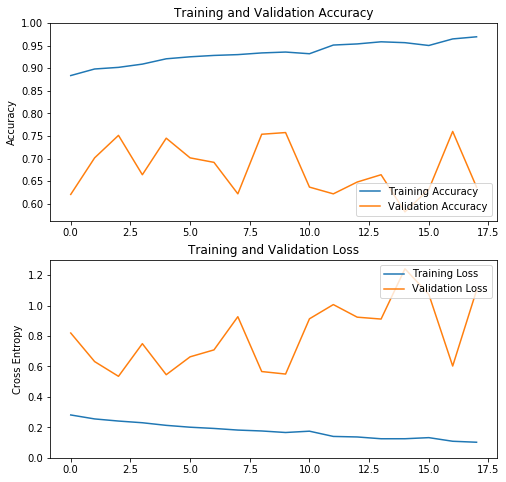

Training Acc:  [0.8835569078324494, 0.8980777209732579, 0.9016733508834766, 0.9088646107533713, 0.9206195547610064, 0.9250449454152985, 0.9280874015236112, 0.9298852164539917, 0.9336191398723873, 0.9355552482367584, 0.9318213248843062, 0.9510441156875179, 0.9535333978867666, 0.9582353754997122, 0.9562992670776406, 0.9500760614270245, 0.9645968746008047, 0.9692988521725355]



Evaluating model on test set...
Result on test set: 81.33%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 10s - loss: 0.2436 - acc: 0.9014 - val_loss: 1.0808 - val_acc: 0.5373

Epoch 00001: val_loss improved from inf to 1.08081, saving model to checkpoints/GRAZ_pCNN__run_4.h5
Epoch 2/100
 - 10s - loss: 0.2341 - acc: 0.9051 - val_loss: 0.8650 - val_acc: 0.6032

Epoch 00002: val_loss improved from 1.08081 to 0.86501, saving model to checkpoints/GRAZ_pCNN__run_4.h5
Epoch 3/100
 - 10s - loss: 0.2175 - acc: 0.9156 - val_loss: 0.5750 - val_acc: 0.7276

Epoch 00003: val_loss improved from 0.86501 

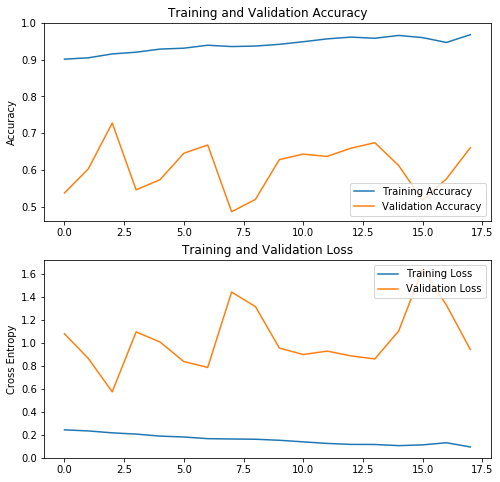

Training Acc:  [0.9013967639742806, 0.9051306873514615, 0.9156409902306221, 0.9203429678105959, 0.9287788688007224, 0.9312681510246998, 0.939289171655154, 0.9356935417366925, 0.9370764763403724, 0.9417784538956174, 0.948831420282064, 0.9565758539785935, 0.9614161250420155, 0.9582353754914692, 0.9659798091879988, 0.9600331904795503, 0.9468953118599923, 0.9679159175935844]



Evaluating model on test set...
Result on test set: 83.08%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 11s - loss: 0.2099 - acc: 0.9188 - val_loss: 0.8620 - val_acc: 0.6206

Epoch 00001: val_loss improved from inf to 0.86203, saving model to checkpoints/GRAZ_pCNN__run_5.h5
Epoch 2/100
 - 11s - loss: 0.1982 - acc: 0.9245 - val_loss: 0.9444 - val_acc: 0.6082

Epoch 00002: val_loss did not improve from 0.86203
Epoch 3/100
 - 11s - loss: 0.1852 - acc: 0.9317 - val_loss: 0.7218 - val_acc: 0.6940

Epoch 00003: val_loss improved from 0.86203 to 0.72181, saving model to checkpoints/GRAZ_pCNN__run_

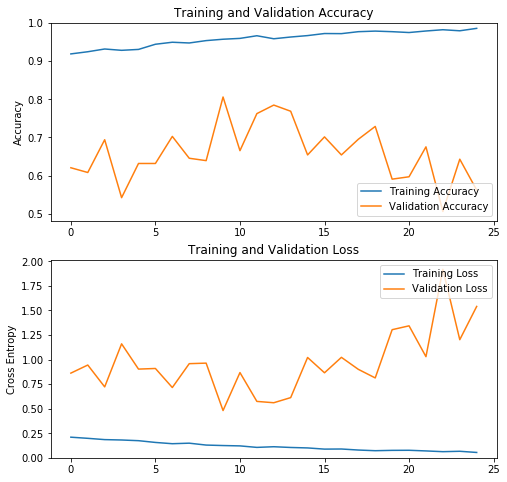

Training Acc:  [0.9188329646017699, 0.9245022123893806, 0.9316924778761062, 0.9282356194690266, 0.9305862831858407, 0.9441371681415929, 0.949391592920354, 0.9474557522123894, 0.9536780973451328, 0.9572732300884956, 0.9594856194690266, 0.9663993362831859, 0.9585176991150443, 0.9630807522123894, 0.9668141592920354, 0.9722068584070797, 0.9719303097345132, 0.9770464601769911, 0.9785674778761062, 0.9770464601769911, 0.9748340707964602, 0.9788440265486725, 0.9821626106194691, 0.9793971238938053, 0.9857577433628318]



Evaluating model on test set...
Result on test set: 81.27%
79.64% (+/- 3.48%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_1 = []
history_1 = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_pCNN_' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_1.append(h)

    history_1.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_1.append(scores[1] * 100)
    ii += 1
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_1), np.std(cvscores_1)))
  cv_all_subjects = np.asarray(cvscores_1)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
pcnn_train_acc_1 = [ 0.9857577433628318, 0.9679159175935844,  0.9692988521725355, 0.9572673212639475,  0.9452357904048171]

In [0]:
cap_df.loc['pCNN_1', 'CV Test Acc'] = np.mean(cvscores_1)
cap_df.loc['pCNN_1', 'Capacity (bits)'] = 3670
cap_df.loc['pCNN_1', 'CV Train Acc'] = np.mean(pcnn_train_acc_1)*100


In [0]:
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
pCNN_og,53192,100,68.252
pCNN_1,3670,96.5095,79.6397


## our pCNN 3304 bits

In [0]:
input_shape = x_subject.shape[1:]
model = Sequential()

# spectrogram creation using STFT
model.add(Spectrogram(n_dft = 32, n_hop = 16, input_shape = input_shape,
        return_decibel_spectrogram = False, power_spectrogram = 2.0,
        trainable_kernel = False, name = 'static_stft'))
model.add(Normalization2D(str_axis = 'freq'))

# Conv Block 1
model.add(Conv2D(filters = 18,  kernel_size = (4, 4),
                strides = (1, 1), name = 'conv1',
                border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2), padding = 'valid',
                      data_format = 'channels_last'))

# Conv Block 2
model.add(Conv2D(filters = 11, kernel_size = (2, 2),
                name = 'conv2', border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid',
                      data_format = 'channels_last'))


# # Conv Block 3
model.add(Conv2D(filters = 9, kernel_size = (2, 2),
                name = 'conv3', border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2),
                      padding = 'valid',
                      data_format = 'channels_last'))
# model.add(Dropout(dropout))


# classificator
model.add(Flatten())
model.add(Dense(2))  # two classes only
model.add(Activation('softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=18, kernel_size=(4, 4), strides=(1, 1), name="conv1", padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=11, kernel_size=(2, 2), name="conv2", padding="same")`


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
static_stft (Spectrogram)    (None, 17, 63, 3)         1088      
_________________________________________________________________
normalization2d_29 (Normaliz (None, 17, 63, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 17, 63, 18)        882       
_________________________________________________________________
batch_normalization_66 (Batc (None, 17, 63, 18)        68        
_________________________________________________________________
activation_77 (Activation)   (None, 17, 63, 18)        0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 8, 31, 18)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 31, 11)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=9, kernel_size=(2, 2), name="conv3", padding="same")`


Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 14s - loss: 0.7672 - acc: 0.5564 - val_loss: 1.1276 - val_acc: 0.1331

Epoch 00001: val_loss improved from inf to 1.12756, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 2/100
 - 11s - loss: 0.6683 - acc: 0.5926 - val_loss: 1.0350 - val_acc: 0.1368

Epoch 00002: val_loss improved from 1.12756 to 1.03499, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 3/100
 - 11s - loss: 0.6455 - acc: 0.6330 - val_loss: 0.9255 - val_acc: 0.2276

Epoch 00003: val_loss improved from 1.03499 to 0.92545, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 4/100
 - 11s - loss: 0.6213 - acc: 0.6563 - val_loss: 0.7958 - val_acc: 0.4067

Epoch 00004: val_loss improved from 0.92545 to 0.79580, saving model to checkpoints/GRAZ_pCNN__run_1.h5
Epoch 5/100
 - 11s - loss: 0.5914 - acc: 0.6888 - val_loss: 0.8283 - val_acc: 0.4017

Epoch 00005: val_loss did not improve from 0.79580
Epoch 6/100
 - 10s - loss: 0.5542 - acc: 0.7197 - v

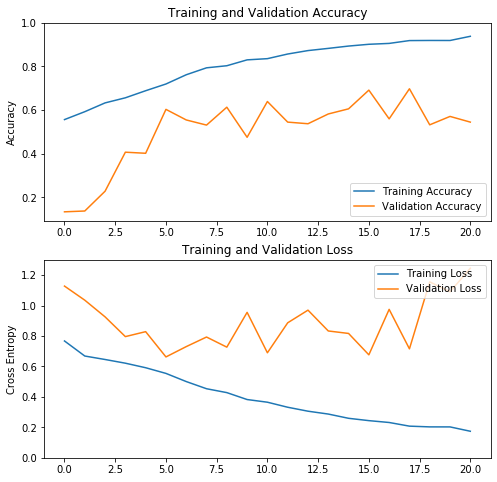

Training Acc:  [0.5563545846012581, 0.5925874708187133, 0.6329691607730218, 0.6563407553295726, 0.6888397180626887, 0.7196791593488726, 0.7621352511097857, 0.7939427466152483, 0.8034849952339154, 0.8304522197501423, 0.835983958024732, 0.8572811506757629, 0.8730466049697748, 0.8831420274398053, 0.8937906237529564, 0.901949937833887, 0.9059604481285067, 0.9189600332398877, 0.9195132070582794, 0.9193749136737465, 0.938597704361557]



Evaluating model on test set...
Result on test set: 66.65%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 11s - loss: 0.5184 - acc: 0.7498 - val_loss: 0.8720 - val_acc: 0.5037

Epoch 00001: val_loss improved from inf to 0.87196, saving model to checkpoints/GRAZ_pCNN__run_2.h5
Epoch 2/100
 - 11s - loss: 0.4897 - acc: 0.7703 - val_loss: 0.7298 - val_acc: 0.5920

Epoch 00002: val_loss improved from 0.87196 to 0.72979, saving model to checkpoints/GRAZ_pCNN__run_2.h5
Epoch 3/100
 - 11s - loss: 0.4643 - acc: 0.7866 - val_loss: 0.8669 - val_

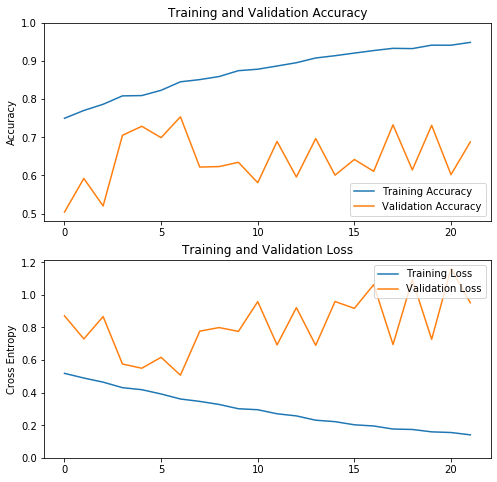

Training Acc:  [0.7498271333332165, 0.7702945651989592, 0.78661319330312, 0.8086018531982903, 0.8094316139588497, 0.82326095983079, 0.8455262066598849, 0.8513345319920433, 0.8593555525647969, 0.8747061264826506, 0.8785783433185509, 0.8870142442757057, 0.8955884387080657, 0.9080348500257837, 0.9139814687342321, 0.9208961416866881, 0.9275342276722477, 0.9333425529302197, 0.9326510856448657, 0.941640160436898, 0.9415018670029074, 0.9489697137490263]



Evaluating model on test set...
Result on test set: 76.95%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 11s - loss: 0.3577 - acc: 0.8390 - val_loss: 0.8422 - val_acc: 0.6405

Epoch 00001: val_loss improved from inf to 0.84216, saving model to checkpoints/GRAZ_pCNN__run_3.h5
Epoch 2/100
 - 11s - loss: 0.3318 - acc: 0.8555 - val_loss: 0.7960 - val_acc: 0.6555

Epoch 00002: val_loss improved from 0.84216 to 0.79596, saving model to checkpoints/GRAZ_pCNN__run_3.h5
Epoch 3/100
 - 11s - loss: 0.3139 - acc: 0.8639 - val_l

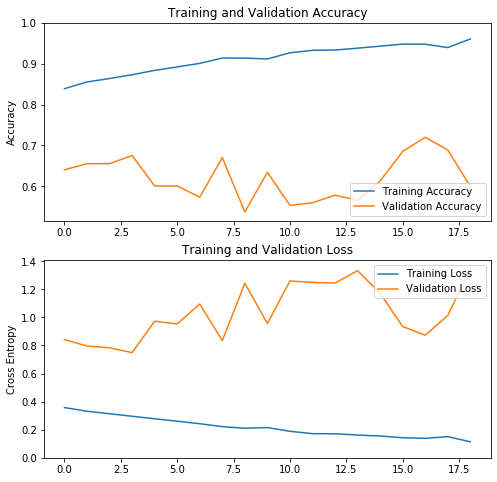

Training Acc:  [0.8390264141577736, 0.8554833357288966, 0.8639192366695655, 0.8731848983707937, 0.8838334947498883, 0.892269395715286, 0.9009818835733936, 0.9139814687259892, 0.9138431752260552, 0.9117687733699928, 0.9268427603621648, 0.9329276725540615, 0.9336191398559014, 0.9381828239853988, 0.9431613885240261, 0.948139952980224, 0.9478633661452146, 0.9397040520148263, 0.9607246577566614]



Evaluating model on test set...
Result on test set: 79.44%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 11s - loss: 0.2940 - acc: 0.8790 - val_loss: 0.6689 - val_acc: 0.7127

Epoch 00001: val_loss improved from inf to 0.66892, saving model to checkpoints/GRAZ_pCNN__run_4.h5
Epoch 2/100
 - 11s - loss: 0.2677 - acc: 0.8881 - val_loss: 0.7475 - val_acc: 0.6878

Epoch 00002: val_loss did not improve from 0.66892
Epoch 3/100
 - 10s - loss: 0.2536 - acc: 0.8939 - val_loss: 0.9448 - val_acc: 0.6231

Epoch 00003: val_loss did not improve from 0.66892
Epoch 4/100
 - 11s - loss: 0

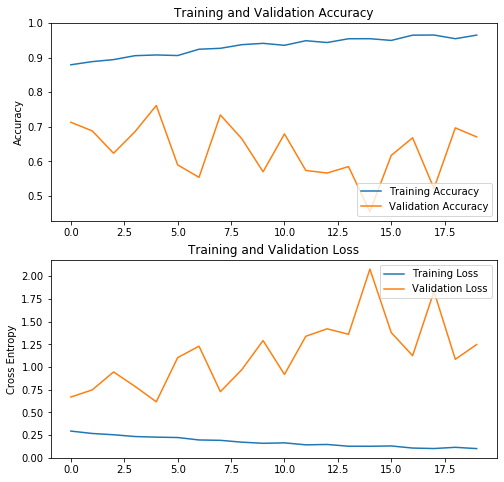

Training Acc:  [0.8789932236534945, 0.8881205919537039, 0.8939289172116758, 0.9052689808596386, 0.9073433827651584, 0.9056838612028251, 0.9239385977373004, 0.9265661734199973, 0.9370764763238865, 0.9409486931680298, 0.9352786613440484, 0.9485548333563822, 0.9432996819497738, 0.9542248651886065, 0.954363158639083, 0.9493845941169415, 0.9645968745843188, 0.9650117549687199, 0.9543631586555689, 0.9647351680347953]



Evaluating model on test set...
Result on test set: 82.28%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 11s - loss: 0.2222 - acc: 0.9100 - val_loss: 0.8130 - val_acc: 0.6878

Epoch 00001: val_loss improved from inf to 0.81304, saving model to checkpoints/GRAZ_pCNN__run_5.h5
Epoch 2/100
 - 10s - loss: 0.2096 - acc: 0.9155 - val_loss: 0.7026 - val_acc: 0.7400

Epoch 00002: val_loss improved from 0.81304 to 0.70264, saving model to checkpoints/GRAZ_pCNN__run_5.h5
Epoch 3/100
 - 10s - loss: 0.1895 - acc: 0.9246 - val_loss: 1.0324 - val_acc: 0.6343

Epoch

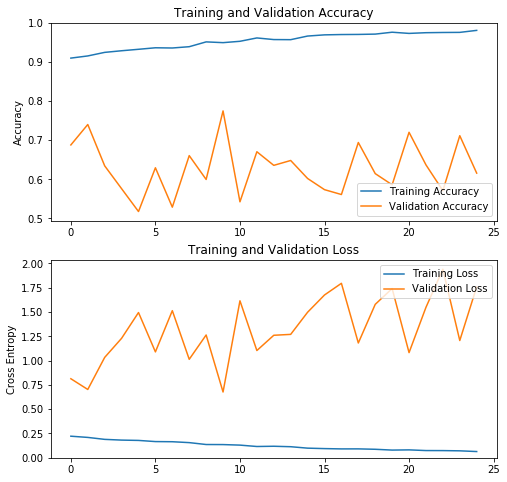

Training Acc:  [0.909983407079646, 0.9155143805309734, 0.9246404867256637, 0.9287887168141593, 0.9325221238938053, 0.9363938053097345, 0.9358407079646017, 0.9391592920353983, 0.9514657079646017, 0.9495298672566371, 0.9529867256637168, 0.9615597345132744, 0.9574115044247787, 0.9571349557522124, 0.9663993362831859, 0.969441371681416, 0.9702710176991151, 0.9705475663716814, 0.9713772123893806, 0.9762168141592921, 0.973174778761062, 0.9749723451327433, 0.9755254424778761, 0.9758019911504425, 0.9809181415929203]



Evaluating model on test set...
Result on test set: 81.82%
77.43% (+/- 5.71%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_2 = []
history_2 = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_pCNN_' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_2.append(h)

    history_2.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_2.append(scores[1] * 100)
    ii += 1
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_2), np.std(cvscores_2)))
  cv_all_subjects = np.asarray(cvscores_2)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
pcnn_train_acc_2 = [0.9809181415929203, 0.9647351680347953,0.9607246577566614,  0.9489697137490263, 0.938597704361557]

In [0]:
cap_df.loc['pCNN_2', 'CV Test Acc'] = np.mean(cvscores_2)
cap_df.loc['pCNN_2', 'Capacity (bits)'] = 3304
cap_df.loc['pCNN_2', 'CV Train Acc'] = np.mean(pcnn_train_acc_2)*100


In [0]:
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
pCNN_og,53192,100,68.252
pCNN_1,3670,96.5095,79.6397
pCNN_2,3304,95.8789,77.4297


## our pCNN 3051 bits

In [0]:
input_shape = x_subject.shape[1:]
model = Sequential()

# spectrogram creation using STFT
model.add(Spectrogram(n_dft = 32, n_hop = 16, input_shape = input_shape,
        return_decibel_spectrogram = False, power_spectrogram = 2.0,
        trainable_kernel = False, name = 'static_stft'))
model.add(Normalization2D(str_axis = 'freq'))

# Conv Block 1
model.add(Conv2D(filters = 17,  kernel_size = (4, 4),
                strides = (1, 1), name = 'conv1',
                border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2), padding = 'valid',
                      data_format = 'channels_last'))

# Conv Block 2
model.add(Conv2D(filters = 10, kernel_size = (2, 2),
                name = 'conv2', border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid',
                      data_format = 'channels_last'))


# # Conv Block 3
model.add(Conv2D(filters = 8, kernel_size = (2, 2),
                name = 'conv3', border_mode = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2),
                      padding = 'valid',
                      data_format = 'channels_last'))
# model.add(Dropout(dropout))


# classificator
model.add(Flatten())
model.add(Dense(2))  # two classes only
model.add(Activation('softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=17, kernel_size=(4, 4), strides=(1, 1), name="conv1", padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=10, kernel_size=(2, 2), name="conv2", padding="same")`


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
static_stft (Spectrogram)    (None, 17, 63, 3)         1088      
_________________________________________________________________
normalization2d_31 (Normaliz (None, 17, 63, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 17, 63, 17)        833       
_________________________________________________________________
batch_normalization_72 (Batc (None, 17, 63, 17)        68        
_________________________________________________________________
activation_85 (Activation)   (None, 17, 63, 17)        0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 8, 31, 17)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 31, 10)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=8, kernel_size=(2, 2), name="conv3", padding="same")`


In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_3 = []
history_3 = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_pCNN_' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_3.append(h)

    history_3.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_3.append(scores[1] * 100)
    ii += 1
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_3), np.std(cvscores_3)))
  cv_all_subjects = np.asarray(cvscores_3)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')